# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [750]:
# ----------------------------
# Standard Library Imports
# ----------------------------
import sys
import time
from collections import Counter
import warnings
import os
# ----------------------------
# Data Handling & Visualization
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Encoding
# ----------------------------
import category_encoders as ce

# ----------------------------
# Scikit-learn Preprocessing & Utilities
# ----------------------------
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline

# ----------------------------
# Scikit-learn Models
# ----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier 

# ----------------------------
# Scikit-learn Metrics
# ----------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    roc_curve, auc, precision_recall_curve
)

# ----------------------------
# Imbalanced-learn
# ----------------------------
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ----------------------------
# SciPy
# ----------------------------
from scipy.sparse import issparse

# ----------------------------
# 🚫 Warnings
# ----------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['PYTHONWARNINGS'] = "ignore"

In [751]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
pd.set_option('display.max_colwidth', None)

In [752]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



## EDA ##

In [755]:
# Declare some reusable functions 
def prepare_conversion_rate(df, column_name):
    """
    Calculates yes/no counts, totals, percentages, and conversion rate
    for a given categorical column and returns a sorted DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame with 'y' as target.
        column_name (str): Name of the column to group by.

    Returns:
        pd.DataFrame: DataFrame with conversion rate statistics, sorted by conversion rate.
    """
    target_counts = df.groupby(column_name)['y'].value_counts().unstack(fill_value=0)

    target_counts['total'] = target_counts['yes'] + target_counts['no']
    target_counts['percent_yes'] = (target_counts['yes'] / target_counts['total']) * 100
    target_counts['percent_no'] = (target_counts['no'] / target_counts['total']) * 100
    target_counts['conversion_rate'] = ((target_counts['yes'] / target_counts['total']) * 100).round(2)

    return target_counts.sort_values(by='total', ascending=False)

def plot_stacked_counts_with_percent(df_sorted, title, xlabel):
    min_height_for_inside = 300  # adjust as needed
    offset = 200  # height offset above small bars

    ax = df_sorted[['no', 'yes']].plot(
        kind='bar',
        stacked=True,
        figsize=(10, 5),
        color=['#6BAED6', '#E69F00']
    )

    for idx, row in df_sorted.iterrows():
        total = row['total']
        x_pos = df_sorted.index.get_loc(idx)

        # % NO inside bar
        if row['no'] > min_height_for_inside:
            ax.text(
                x=x_pos,
                y=row['no'] / 2,
                s=f"{(row['no'] / total * 100):.1f}%",
                ha='center',
                va='center',
                color='white',
                fontsize=9
            )

        # % YES (inside if big, else outside)
        yes_pct = (row['yes'] / total * 100)
        if row['yes'] > 0:
            if row['yes'] > min_height_for_inside:
                ax.text(
                    x=x_pos,
                    y=row['no'] + (row['yes'] / 2),
                    s=f"{yes_pct:.1f}%",
                    ha='center',
                    va='center',
                    color='white',
                    fontsize=9
                )
            else:
                ax.text(
                    x=x_pos,
                    y=row['no'] + row['yes'] + offset,
                    s=f"{yes_pct:.1f}%",
                    ha='center',
                    va='bottom',
                    color='black',
                    fontsize=9
                )
        else:
            # Optionally show 0% just above "no" bar
            ax.text(
                x=x_pos,
                y=row['no'] + offset / 2,
                s="0.0%",
                ha='center',
                va='bottom',
                color='gray',
                fontsize=8
            )

    # Style
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count of Clients')
    plt.xticks(rotation=45)
    plt.legend(title='Subscribed (y)', labels=['No', 'Yes'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
def prepare_and_plot_conversion_rate(df_counts, title, xlabel):
    """
    Sorts by conversion rate and plots a bar chart with percentage annotations.

    Parameters:
        df_counts (pd.DataFrame): Grouped DataFrame with 'yes', 'no', and 'conversion_rate' columns.
        title (str): Title for the chart.
        xlabel (str): Label for the x-axis.
    """
    # Sort by conversion rate
    df_sorted = df_counts.sort_values(by='conversion_rate', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_sorted.index, df_sorted['conversion_rate'], color='#6BAED6')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords='offset points',
                     ha='center', va='bottom',
                     fontsize=9)

    # Labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Conversion Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [756]:
# Feature details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [757]:
#Check for missing values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [758]:
#Check for duplicates 
df.duplicated().sum()

12

In [759]:
# Describe data frame
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Age Feature 

In [761]:
# Value counts
df['age'].value_counts()

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

<Axes: xlabel='y', ylabel='age'>

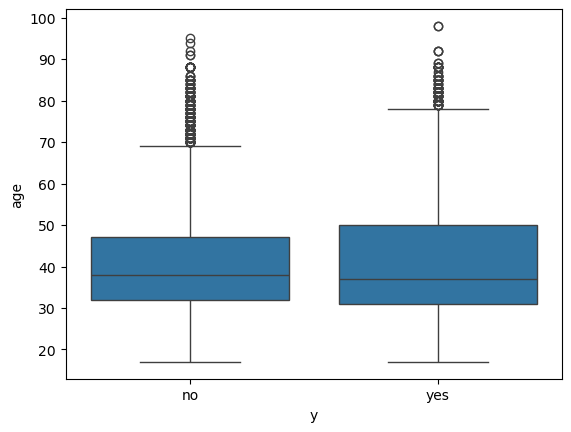

In [762]:
# Plot
sns.boxplot(x='y', y='age', data=df)

<Axes: xlabel='age', ylabel='Count'>

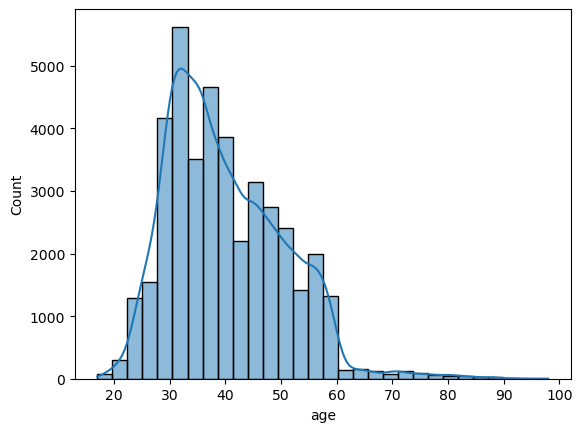

In [763]:
# Age histplot
sns.histplot(df['age'], bins=30, kde=True)

In [764]:
# Group by age and get value counts for y
age_target_counts = df.groupby('age')['y'].value_counts().unstack(fill_value=0)
age_target_counts

y,no,yes
age,,
17,3,2
18,16,12
19,22,20
20,42,23
21,73,29
...,...,...
91,2,0
92,1,3
94,1,0


In [765]:
# Add total and conversion rate
age_target_counts['total'] = age_target_counts['yes'] + age_target_counts['no']
age_target_counts['conversion_rate'] = (age_target_counts['yes'] / age_target_counts['total']) * 100

# Sort by age and plot
age_target_counts = age_target_counts.sort_index()
age_target_counts


y,no,yes,total,conversion_rate
age,,,,
17,3,2,5,40.000000
18,16,12,28,42.857143
19,22,20,42,47.619048
20,42,23,65,35.384615
21,73,29,102,28.431373
...,...,...,...,...
91,2,0,2,0.000000
92,1,3,4,75.000000
94,1,0,1,0.000000


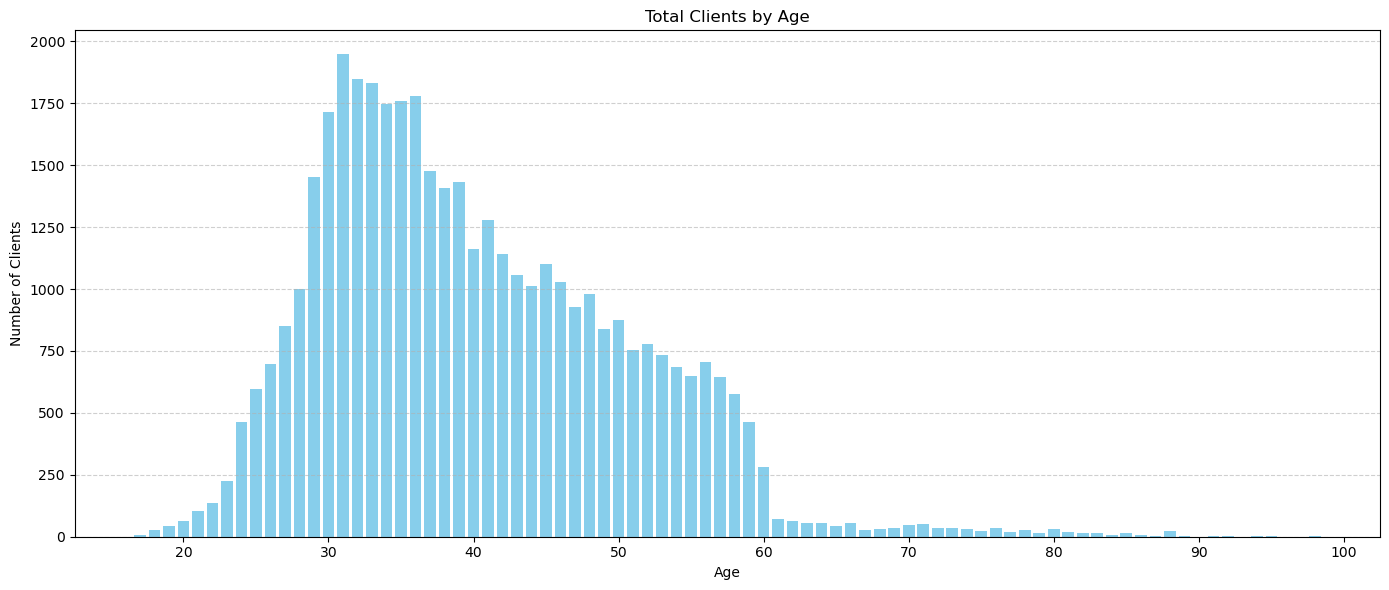

In [766]:
# Group by age and count total clients
age_totals = df['age'].value_counts().sort_index()

# Plot total number of clients by age
plt.figure(figsize=(14, 6))
plt.bar(age_totals.index, age_totals.values, color='skyblue')
plt.title('Total Clients by Age')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


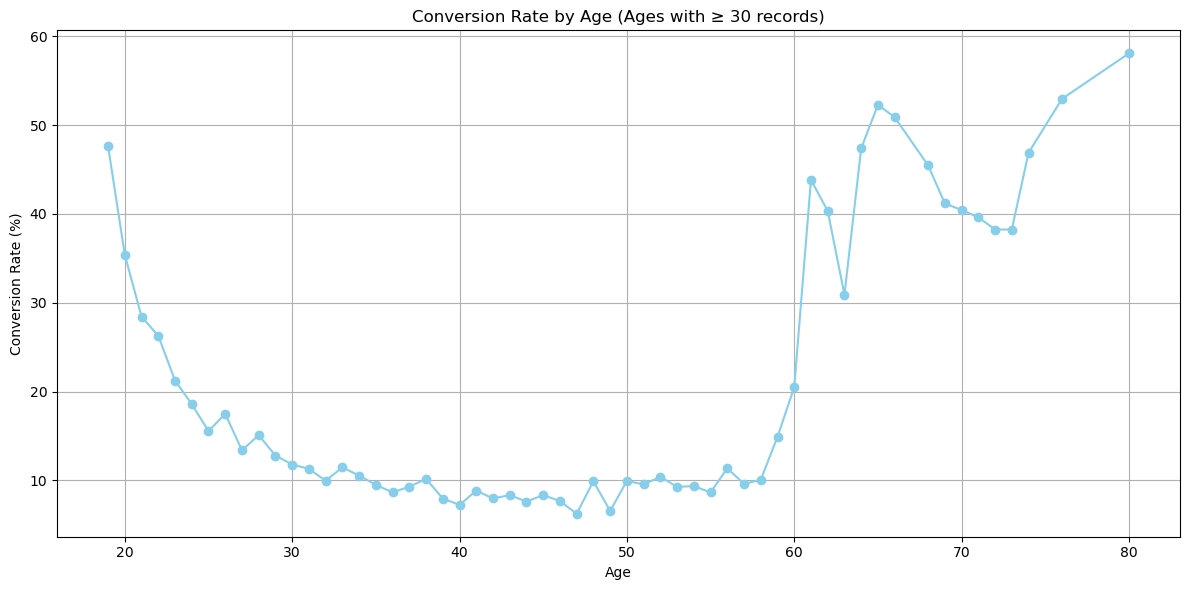

In [767]:
# Filter to ages with a minimum number of records (to reduce noise)
age_conversion_filtered = age_target_counts[age_target_counts['total'] >= 30]

# Plot conversion rate by age
plt.figure(figsize=(12, 6))
plt.plot(age_conversion_filtered.index, age_conversion_filtered['conversion_rate'], marker='o', color='skyblue')
plt.title('Conversion Rate by Age (Ages with ≥ 30 records)')
plt.xlabel('Age')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:** Most clients fall between the ages of 30 and 40, making this the dominant age group in the dataset. The number of clients gradually declines after age 40, with very few clients above 60. Younger clients under 25 and older clients over 65 are significantly underrepresented, which may limit their influence in model training or targeting strategies.

#### Job Feature

In [770]:
# Job Counts
df['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

In [771]:
# Calls the prepare conversation rate method
job_target_counts_sorted = prepare_conversion_rate(df, 'job')
job_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
job,,,,,,
admin.,9070,1352,10422,12.972558,87.027442,12.97
blue-collar,8616,638,9254,6.894316,93.105684,6.89
technician,6013,730,6743,10.826042,89.173958,10.83
services,3646,323,3969,8.138070,91.861930,8.14
management,2596,328,2924,11.217510,88.782490,11.22
retired,1286,434,1720,25.232558,74.767442,25.23
entrepreneur,1332,124,1456,8.516484,91.483516,8.52
self-employed,1272,149,1421,10.485574,89.514426,10.49
housemaid,954,106,1060,10.000000,90.000000,10.00


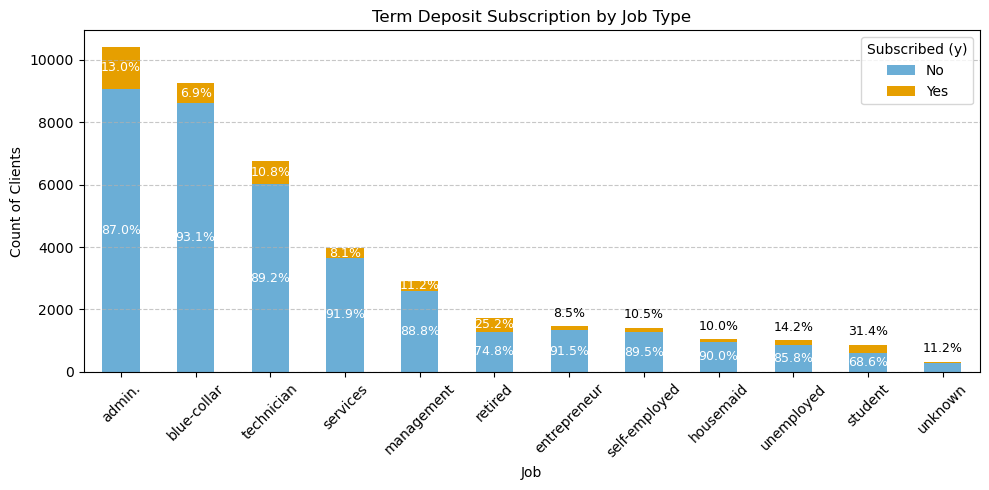

In [772]:
# Calls the plot stacked counts with percent method 
plot_stacked_counts_with_percent(
    job_target_counts_sorted, 
    'Term Deposit Subscription by Job Type', 
    'Job')

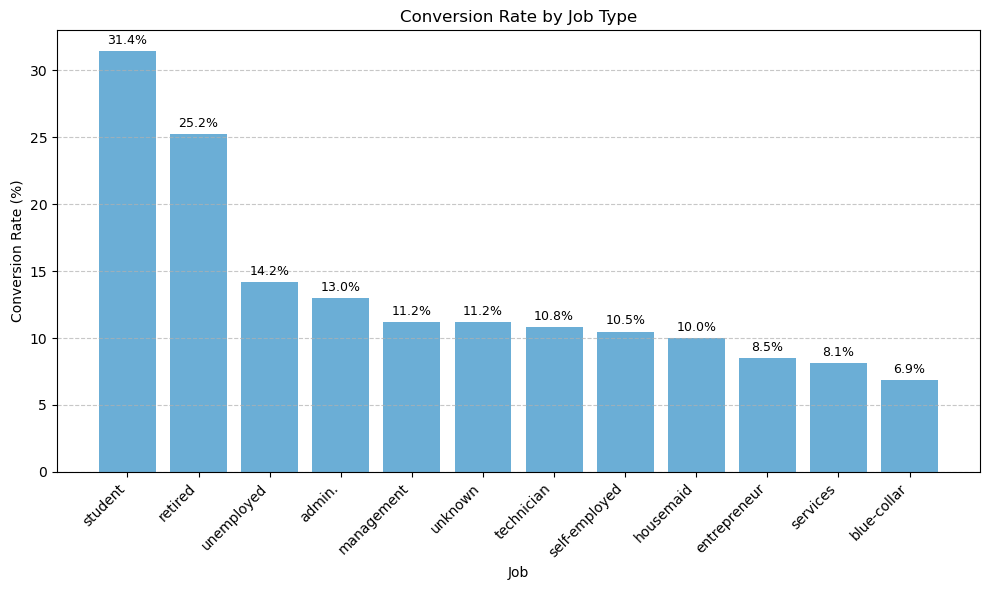

In [773]:
# Calls prepare plot conversion rate method 
prepare_and_plot_conversion_rate(
    job_target_counts_sorted, 
    "Conversion Rate by Job Type", "Job")

**Insight:** The highest conversion rates are observed among students (31.4%) and retired individuals (25.2%), despite students having a relatively small total count. On the other hand, blue-collar workers, who represent one of the largest groups, show the lowest conversion rate at only 6.9%. This suggests that while some groups are highly responsive, targeting larger but low-converting groups like blue-collar workers may require different strategies.

#### Marital Feature

In [776]:
# Marital value counts
df['marital'].value_counts()

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

In [777]:
# Calls the prepare conversation rate method
marital_target_counts_sorted = prepare_conversion_rate(df, 'marital')
marital_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
marital,,,,,,
married,22396,2532,24928,10.157253,89.842747,10.16
single,9948,1620,11568,14.004149,85.995851,14.00
divorced,4136,476,4612,10.320902,89.679098,10.32
unknown,68,12,80,15.000000,85.000000,15.00


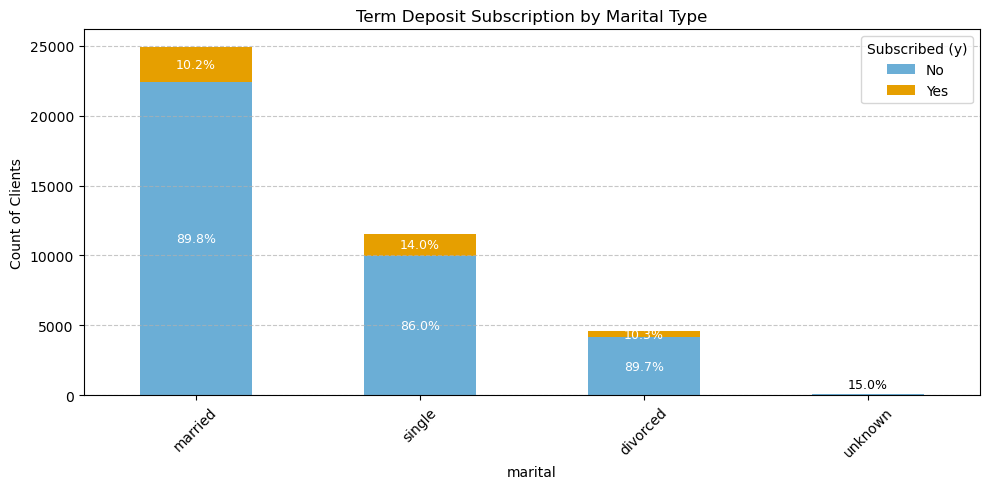

In [778]:
# Calls the plot stacked counts with percent method 
plot_stacked_counts_with_percent(
    marital_target_counts_sorted, 
    'Term Deposit Subscription by Marital Type', 
    'marital')

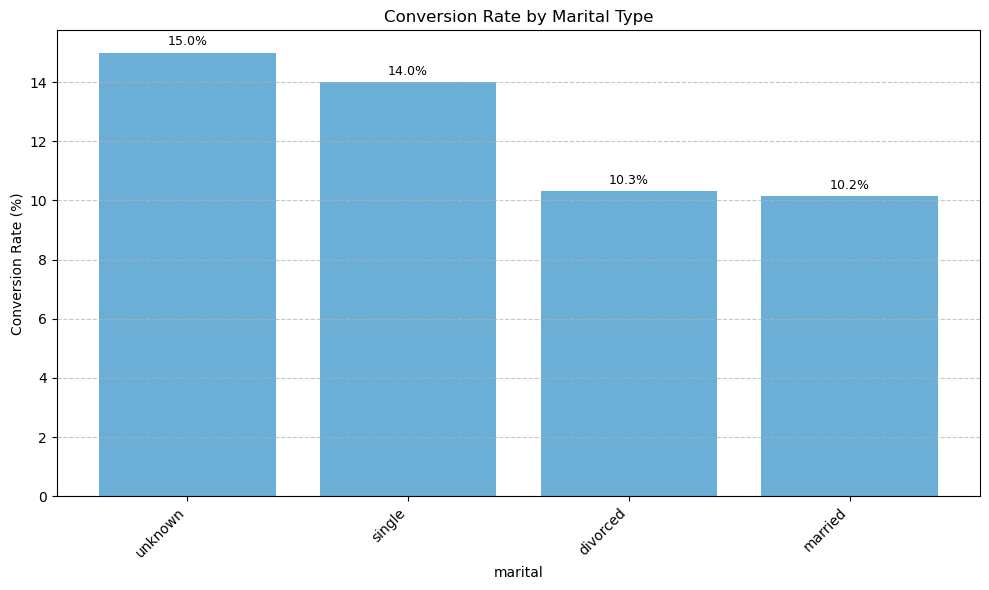

In [779]:
# Calls prepare plot conversion rate method 
prepare_and_plot_conversion_rate(
    marital_target_counts_sorted, 
    "Conversion Rate by Marital Type",
    "marital")

**Insight:** The marital status analysis shows that married clients make up the largest portion of the dataset but have the lowest conversion rate at around 10.2%. Single clients, while fewer, convert at a higher rate of approximately 14%, suggesting they may be more receptive to marketing efforts. Although the "unknown" group has the highest conversion rate (15%), its small size limits its reliability for strategic decisions.

#### Education Feature

In [782]:
# Education value counts
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [783]:
# Calls the prepare conversation rate method
education_target_counts_sorted = prepare_conversion_rate(df, 'education')
education_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
education,,,,,,
university.degree,10498,1670,12168,13.724523,86.275477,13.72
high.school,8484,1031,9515,10.835523,89.164477,10.84
basic.9y,5572,473,6045,7.824648,92.175352,7.82
professional.course,4648,595,5243,11.348465,88.651535,11.35
basic.4y,3748,428,4176,10.249042,89.750958,10.25
basic.6y,2104,188,2292,8.202443,91.797557,8.20
unknown,1480,251,1731,14.500289,85.499711,14.50
illiterate,14,4,18,22.222222,77.777778,22.22


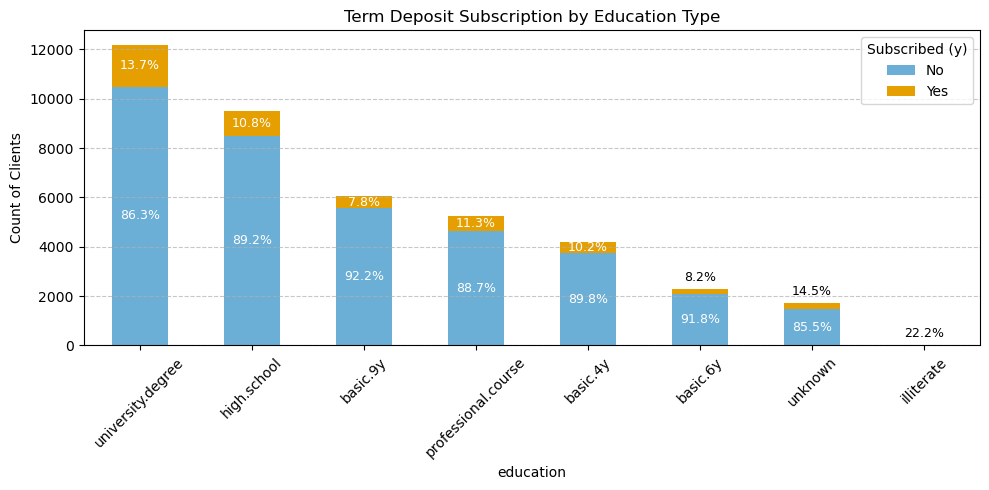

In [784]:
# Calls the plot stacked counts with percent method 
plot_stacked_counts_with_percent(
    education_target_counts_sorted, 
    'Term Deposit Subscription by Education Type', 
    'education')

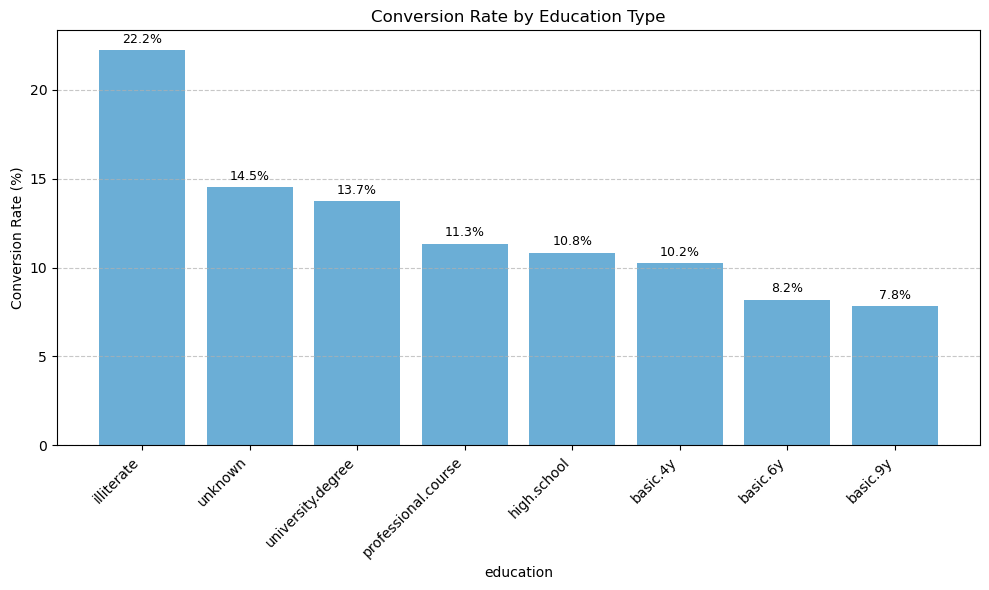

In [785]:
# Calls prepare plot conversion rate method 
prepare_and_plot_conversion_rate(
    education_target_counts_sorted, 
    "Conversion Rate by Education Type", 
    "education")

**Insight:** The conversion rate is highest among the illiterate group (22.2%), but this group is extremely small in total count. University degree holders and high school graduates have moderate conversion rates (14.5% and 13.7%) but represent the largest segments of the population, making them more impactful for targeting. Overall, focusing on education levels with both high conversion and large population—like university and high school—offers the most strategic marketing opportunity.

#### Default Feature

In [788]:
# Default value counts
df['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [789]:
# Calls the prepare conversation rate method
default_target_counts_sorted = prepare_conversion_rate(df, 'default')
default_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
default,,,,,,
no,28391,4197,32588,12.878974,87.121026,12.88
unknown,8154,443,8597,5.152960,94.847040,5.15
yes,3,0,3,0.000000,100.000000,0.00


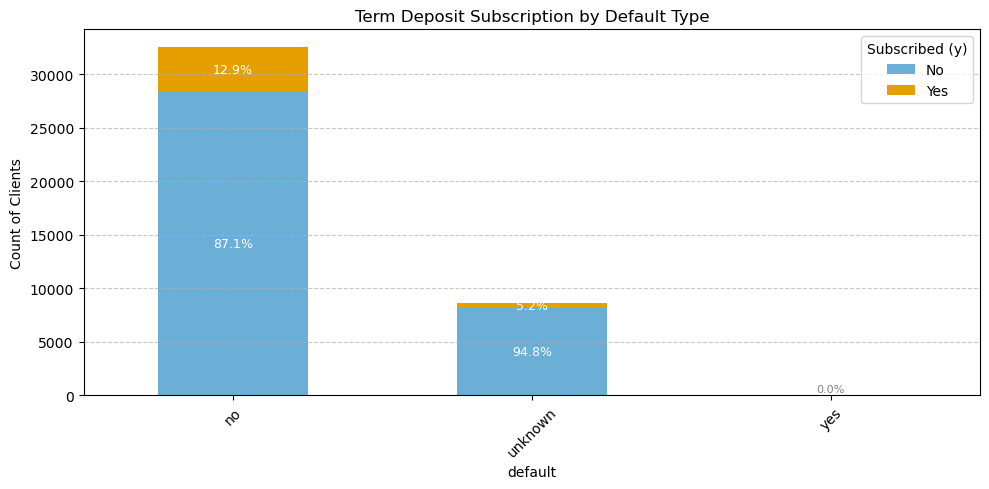

In [790]:
# Calls the plot stacked counts with percent method 
plot_stacked_counts_with_percent(
    default_target_counts_sorted, 
    'Term Deposit Subscription by Default Type', 
    'default')

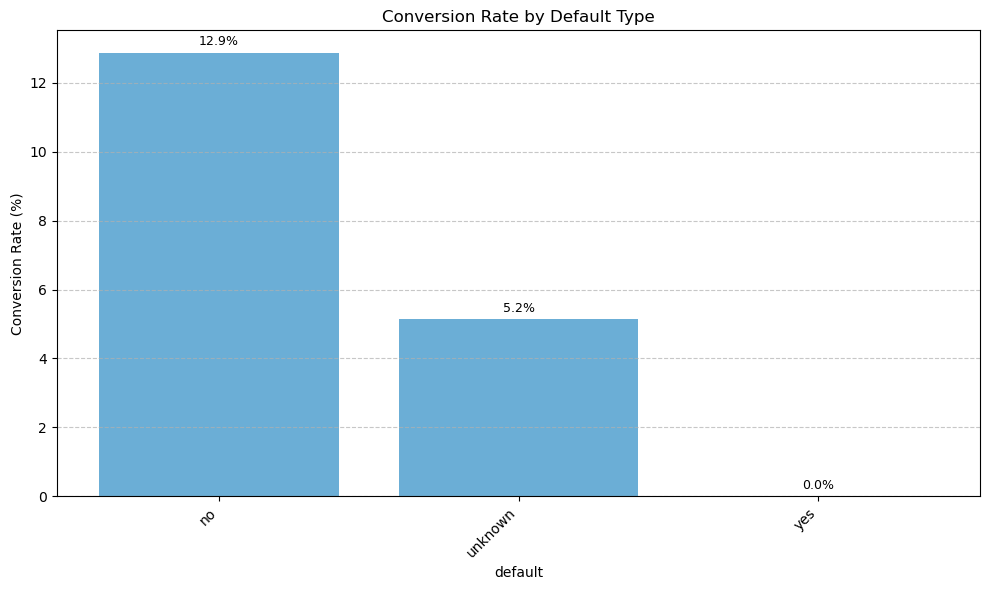

In [791]:
# Calls prepare plot conversion rate method 
prepare_and_plot_conversion_rate(
    default_target_counts_sorted, 
    "Conversion Rate by Default Type", 
    "default")

**Insight:** The majority of clients have not defaulted on credit, with a relatively high subscription rate of 13.3% among this group. Those marked as "unknown" have a lower conversion rate of 5.2%, indicating limited engagement or data quality concerns. Interestingly, clients marked as "yes" for credit default had a 0% subscription rate, suggesting they are the least likely to subscribe, potentially due to risk evaluation criteria.

#### Housing Feature

In [794]:
# Housing value counts
df['housing'].value_counts()

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

In [795]:
# Calls the prepare conversation rate method
housing_target_counts_sorted = prepare_conversion_rate(df, 'housing')
housing_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
housing,,,,,,
yes,19069,2507,21576,11.619392,88.380608,11.62
no,16596,2026,18622,10.879605,89.120395,10.88
unknown,883,107,990,10.808081,89.191919,10.81


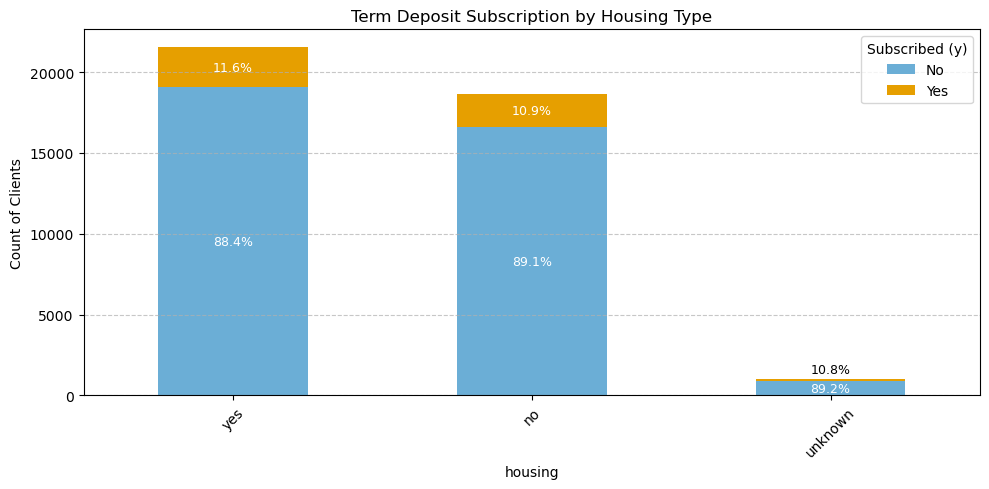

In [796]:
# Calls the plot stacked counts with percent method 
plot_stacked_counts_with_percent(
    housing_target_counts_sorted, 
    'Term Deposit Subscription by Housing Type', 
    'housing')

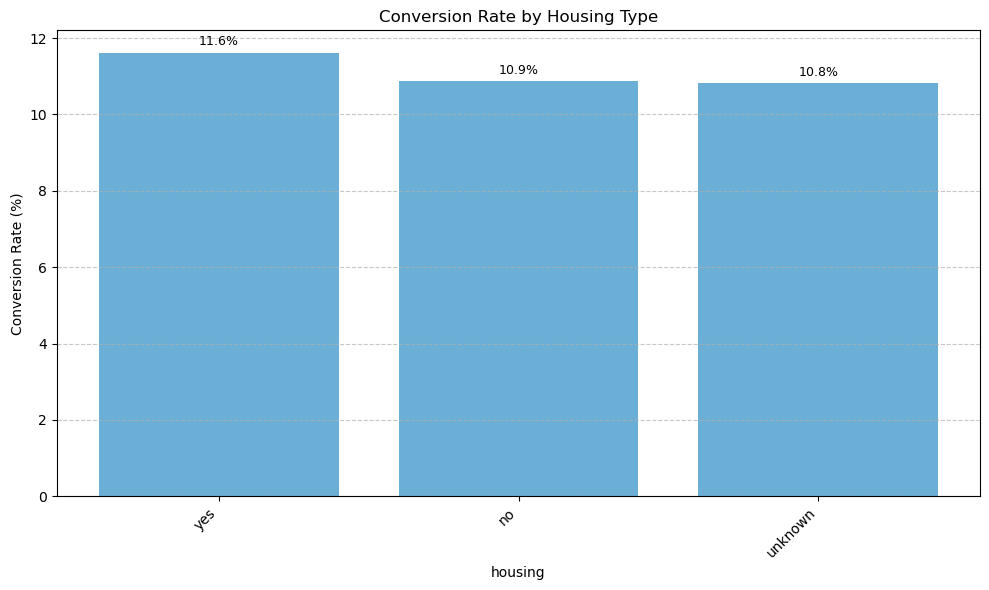

In [797]:
# Calls prepare plot conversion rate method 
prepare_and_plot_conversion_rate(
    housing_target_counts_sorted, 
    "Conversion Rate by Housing Type", "housing")

**Insight:** The analysis shows that clients with a housing loan have a slightly higher term deposit subscription rate (11.6%) compared to those without a housing loan (10.9%) or with unknown housing status (10.8%). However, the difference in conversion rates across housing types is minimal, indicating housing status is not a strong predictor of term deposit subscription. The total number of clients is much higher for those with a known housing status, suggesting better reliability and insight from those categories.

#### Loan Feature

In [800]:
# Loan value counts
df['loan'].value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

In [801]:
# Calls the prepare conversation rate method
loan_target_counts_sorted = prepare_conversion_rate(df, 'loan')
loan_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
loan,,,,,,
no,30100,3850,33950,11.340206,88.659794,11.34
yes,5565,683,6248,10.931498,89.068502,10.93
unknown,883,107,990,10.808081,89.191919,10.81


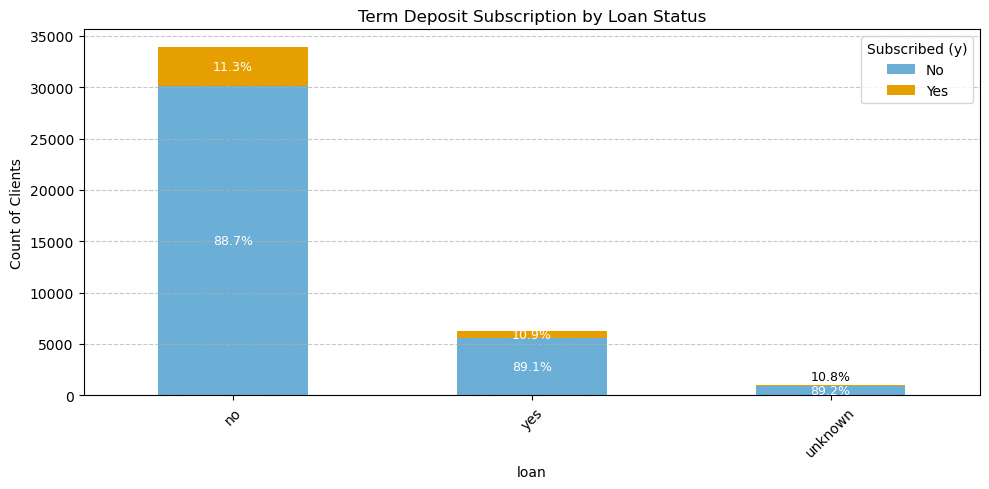

In [802]:
# Calls the plot stacked counts with percent method 
plot_stacked_counts_with_percent(
    loan_target_counts_sorted, 
    'Term Deposit Subscription by Loan Status',
    'loan')

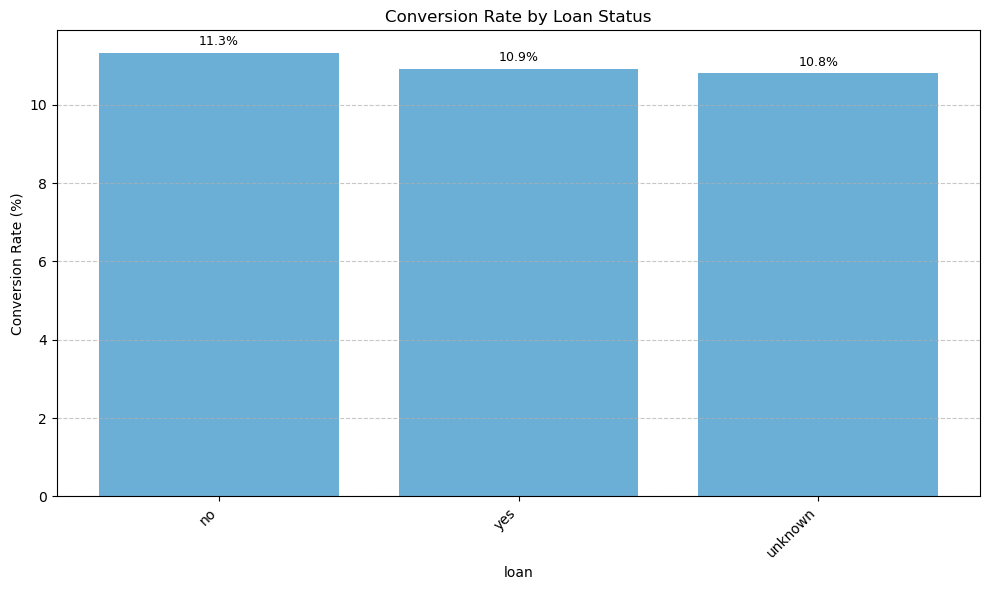

In [803]:
# Calls prepare plot conversion rate method 
prepare_and_plot_conversion_rate(
    loan_target_counts_sorted, 
    "Conversion Rate by Loan Status", 
    "loan")

**Insight:** The visual analysis shows that clients without personal loans have the highest number of subscriptions and a slightly higher conversion rate (11.3%) compared to those with loans (10.9%). Interestingly, clients with unknown loan status exhibit a similar conversion rate (10.8%), suggesting minimal predictive influence of loan status on subscription. The bulk of the dataset consists of clients without loans, making them the dominant group to target for marketing efforts.


#### Contact Feature

In [806]:
# Value counts
df['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [807]:
# Group and calculate subscription metrics (counts, totals, percentages, conversion rate)
contact_target_counts_sorted = prepare_conversion_rate(df, 'contact')
contact_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
contact,,,,,,
cellular,22291,3853,26144,14.737607,85.262393,14.74
telephone,14257,787,15044,5.231321,94.768679,5.23


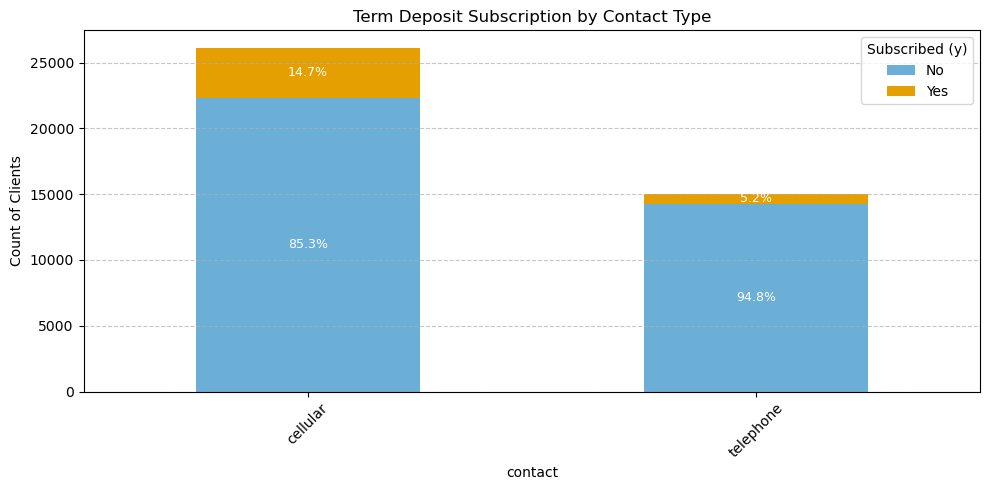

In [808]:
# Visualize number of 'yes' and 'no' subscriptions with percentages stacked by contact type
plot_stacked_counts_with_percent(
    contact_target_counts_sorted,
    'Term Deposit Subscription by Contact Type',
    'contact'
)

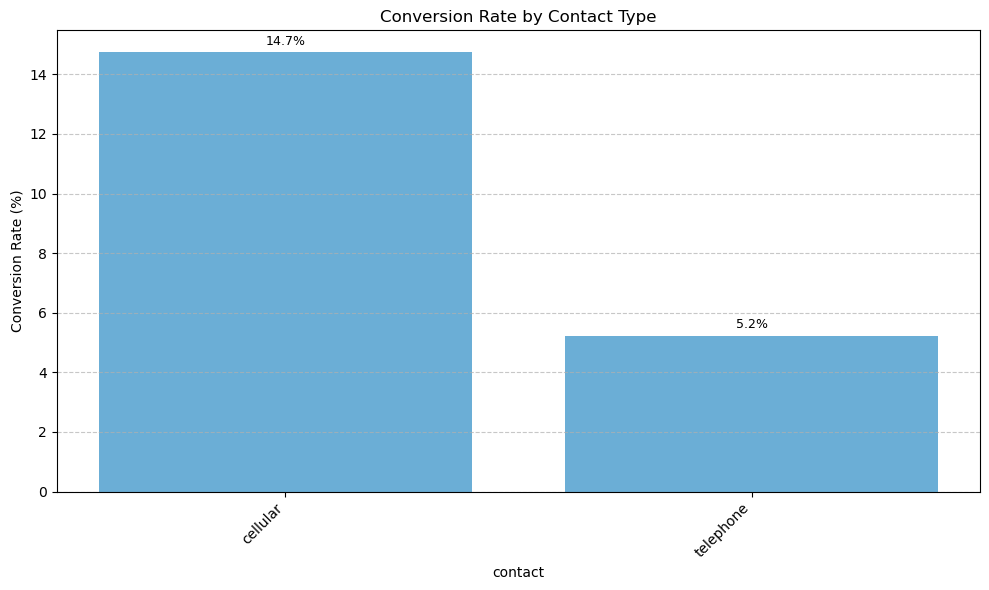

In [809]:
# Visualize conversion rate (% of 'yes') per contact type with value labels
prepare_and_plot_conversion_rate(
    contact_target_counts_sorted,
    "Conversion Rate by Contact Type",
    "contact"
)

**Insight:**  The contact feature has a clear influence on subscription success. Clients contacted via cellular show a significantly higher conversion rate (14.7%) compared to those contacted via telephone (5.2%). Since cellular contacts also represent a larger share of the total client base, marketing efforts should prioritize cellular outreach for better campaign results.

#### Month Feature

In [812]:
# Value counts
df['month'].value_counts()

month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64

In [813]:
# Group and calculate subscription metrics (counts, totals, percentages, conversion rate) for month
month_target_counts_sorted = prepare_conversion_rate(df, 'month')
month_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
month,,,,,,
may,12883,886,13769,6.434745,93.565255,6.43
jul,6525,649,7174,9.046557,90.953443,9.05
aug,5523,655,6178,10.602137,89.397863,10.60
jun,4759,559,5318,10.511470,89.488530,10.51
nov,3685,416,4101,10.143867,89.856133,10.14
apr,2093,539,2632,20.478723,79.521277,20.48
oct,403,315,718,43.871866,56.128134,43.87
sep,314,256,570,44.912281,55.087719,44.91
mar,270,276,546,50.549451,49.450549,50.55


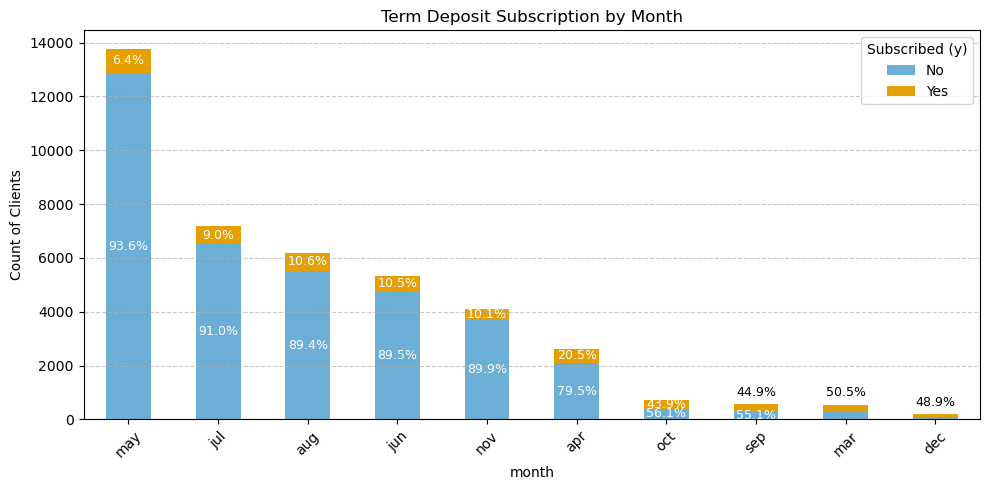

In [814]:
# Visualize number of 'yes' and 'no' subscriptions with percentages stacked by month
plot_stacked_counts_with_percent(
    month_target_counts_sorted,
    'Term Deposit Subscription by Month',
    'month'
)

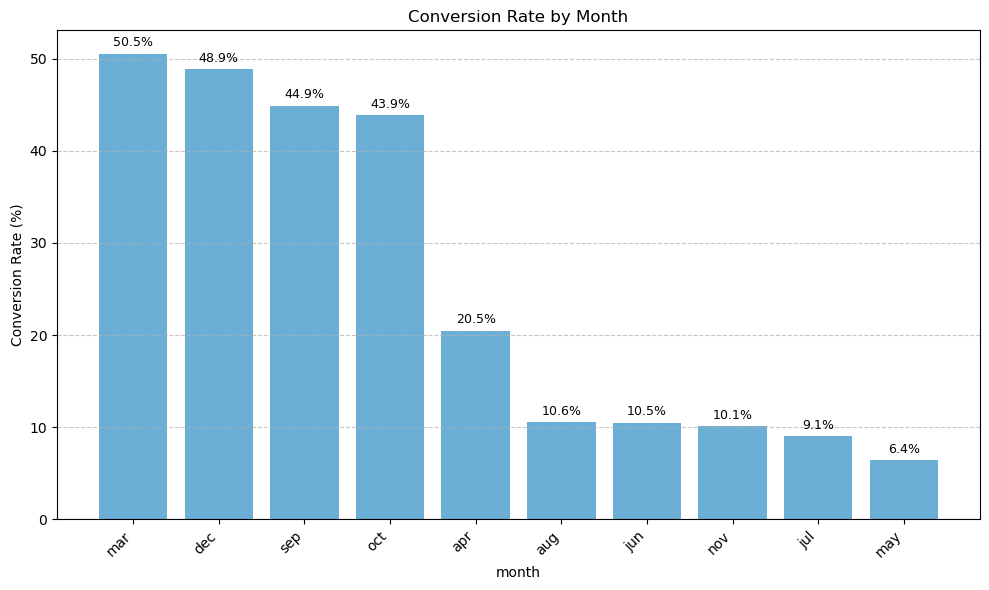

In [815]:
# Visualize conversion rate (% of 'yes') per month with value labels
prepare_and_plot_conversion_rate(
    month_target_counts_sorted,
    "Conversion Rate by Month",
    "month"
)

**Insight:** Clients contacted in March, December, September, and October had the highest conversion rates, with March reaching an impressive 50.5%, indicating these months may align with more effective or targeted marketing efforts. In contrast, May through August show significantly lower conversion rates despite high contact volume, suggesting potential oversaturation or less receptive audiences. These insights suggest that focusing campaigns in late Q3 and Q4 may be more effective, while earlier months might require improved messaging or targeting strategies.

#### Day of the week feature

In [818]:
# Value counts
df['day_of_week'].value_counts()

day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64

In [819]:
# Prepare the grouped counts and conversion rate for day_of_week
day_target_counts_sorted = prepare_conversion_rate(df, 'day_of_week')
day_target_counts_sorted

y,no,yes,total,percent_yes,percent_no,conversion_rate
day_of_week,,,,,,
thu,7578,1045,8623,12.118752,87.881248,12.12
mon,7667,847,8514,9.948320,90.051680,9.95
wed,7185,949,8134,11.667076,88.332924,11.67
tue,7137,953,8090,11.779975,88.220025,11.78
fri,6981,846,7827,10.808739,89.191261,10.81


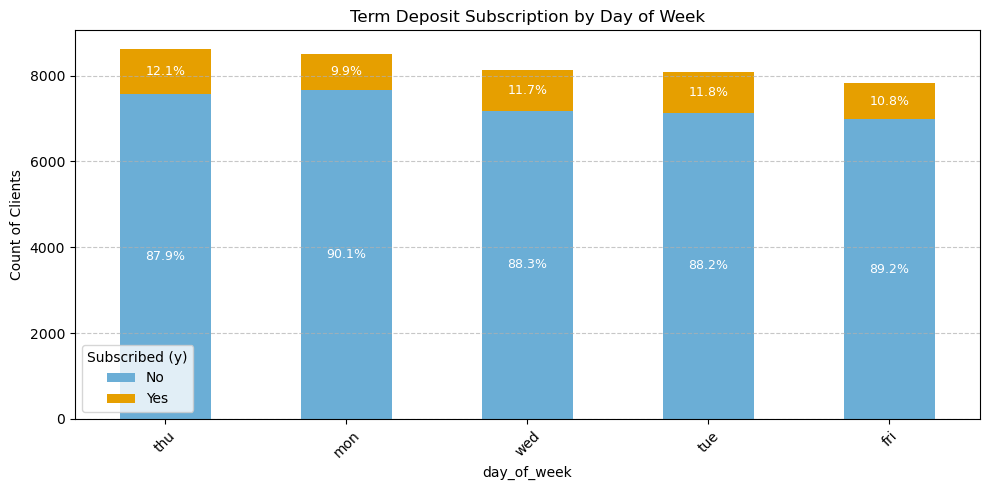

In [820]:
# Plot stacked bar chart of subscription counts with percentage annotations
plot_stacked_counts_with_percent(
    day_target_counts_sorted,
    'Term Deposit Subscription by Day of Week',
    'day_of_week'
)

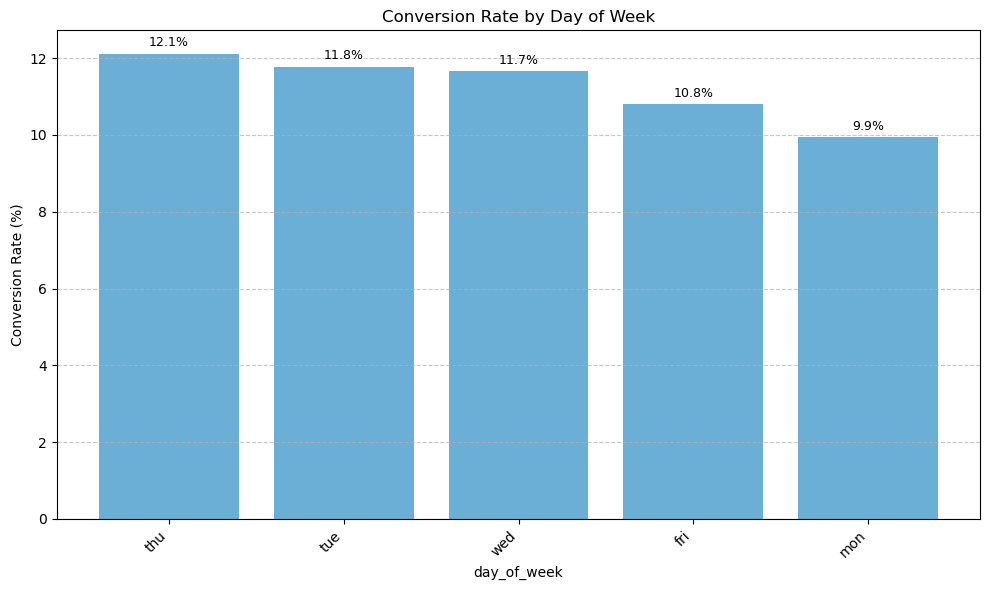

In [821]:
# Plot conversion rate per day of the week
prepare_and_plot_conversion_rate(
    day_target_counts_sorted,
    'Conversion Rate by Day of Week',
    'day_of_week'
)

**Insight:** Term deposit conversion rates vary slightly across the weekdays, with Thursday showing the highest conversion rate at 12.1%, followed closely by Tuesday and Wednesday. Monday has the lowest conversion rate at 9.9%, even though it has one of the highest contact volumes. This suggests that contacting clients later in the week may be more effective for conversion, possibly due to better availability or responsiveness.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The dataset comes from a Portuguese bank's direct marketing campaigns, where human agents called potential clients to convince them to subscribe to a long-term deposit (a type of savings account with fixed interest).

#### Why it matters ####
- Calling customers costs time and money (agents, phone usage, etc.)

- Only a small percentage of people actually subscribe (~11%)

- The bank wants to reduce the number of failed calls and focus efforts on people who are more likely to say yes

#### Business Objective ####

The objective is to build a predictive model that helps the bank identify which customers are most likely to subscribe to a term deposit, so the marketing team can target those customers more efficiently and reduce wasted resources on unlikely leads.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

**Features Engineering should be after train/test split. I will state my plan summary here**

#### Summary of Preprocessing Steps

##### Data Cleaning
- Dropped the `'duration'` column to prevent **data leakage**.
- Removed **duplicate rows** from the dataset.
- Mapped the target variable `'y'` to **binary**:
  - `'yes'` → `1`
  - `'no'` → `0`

---

##### Splitting and Feature Engineering
- Performed a **train-test split** (70/30) with **stratification** on the target.
- Binned the `'age'` column into labeled **age groups**, then dropped the raw `'age'` column.
- Replaced `'unknown'` values in categorical columns:
  - Used the **most common category (mode)** for `job`, `marital`.
  - Used `'other'` for `education`, `default`, `housing`, and `loan`.

---

##### New Feature & Final Setup
- Created a new binary feature: `'contacted_before'` (based on whether `'pdays'` ≠ 999).
- Dropped the original `'pdays'` column.

---

##### Feature Grouping & Transformation
- Defined three groups of features:
  - **`james_stein_cols`** → encoded using `JamesSteinEncoder`
  - **`onehot_cols`** → encoded using `OneHotEncoder`
  - **`numeric_cols`** → standardized using `StandardScaler`
- Combined all transformations into a unified **preprocessing pipeline** using `ColumnTransformer`.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [832]:
# Drop duration
df.drop(columns=['duration'],axis=1,inplace=True)

# Drop duplicates
df = df.drop_duplicates()

# Setup your dataset
X = df.drop('y', axis=1).copy()
y = df['y'].map({'yes': 1, 'no': 0}).copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Age binning
bins = [17, 25, 35, 50, 65, 100]
labels = ['<25', '25–35', '35–50', '50–65', '65+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, include_lowest=True)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, include_lowest=True)

# Drop raw age
X_train.drop(columns='age', inplace=True)
X_test.drop(columns='age', inplace=True)

# Job replace unknown
most_common_job = X_train['job'].mode()[0]
X_train['job'] = X_train['job'].replace('unknown', most_common_job)
X_test['job'] = X_test['job'].replace('unknown', most_common_job)

# Replace 'unknown' in 'marital' with mode in both X_train and X_test
marital_mode = X_train['marital'].mode()[0]
X_train['marital'] = X_train['marital'].replace('unknown', marital_mode)
X_test['marital'] = X_test['marital'].replace('unknown', marital_mode)

# Education replace unknown with 'other'
X_train['education'] = X_train['education'].replace('unknown', 'other')
X_test['education'] = X_test['education'].replace('unknown', 'other')

# Default replace unknown with 'other'
X_train['default'] = X_train['default'].replace('unknown', 'other')
X_test['default'] = X_test['default'].replace('unknown', 'other')

# Replace 'unknown' in housing and loan with 'other'
X_train['housing'] = X_train['housing'].replace('unknown', 'other')
X_test['housing'] = X_test['housing'].replace('unknown', 'other')

X_train['loan'] = X_train['loan'].replace('unknown', 'other')
X_test['loan'] = X_test['loan'].replace('unknown', 'other')

X_train['contacted_before'] = (X_train['pdays'] != 999).astype(int)
X_test['contacted_before'] = (X_test['pdays'] != 999).astype(int)
X_train.drop(columns='pdays', inplace=True)
X_test.drop(columns='pdays', inplace=True)

# Define column types
james_stein_cols = ['job', 'education', 'month']
onehot_cols = ['marital', 'housing', 'loan', 'contact', 'day_of_week', 'age_group', 'default', 'poutcome']
numeric_cols = ['contacted_before', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'previous']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('jstein', ce.JamesSteinEncoder(cols=james_stein_cols), james_stein_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
        ('scalar', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [915]:
# Baseline Model
start_time = time.time()
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
baseline_training_time = round(time.time() - start_time, 4)

# Predict
y_pred_dummy = dummy_clf.predict(X_test)
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Collect metrics
baseline_metrics = {
    "Model": "Baseline Dummy (Stratified)",
    "Train Accuracy": accuracy_score(y_train, dummy_clf.predict(X_train)),
    "Test Accuracy": accuracy_score(y_test, y_pred_dummy),
    "Precision": precision_score(y_test, y_pred_dummy, zero_division=0),
    "Recall": recall_score(y_test, y_pred_dummy, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_dummy, zero_division=0),
    "ROC AUC Train": roc_auc_score(y_train, dummy_clf.predict_proba(X_train)[:, 1]),
    "ROC AUC Test": roc_auc_score(y_test, y_proba_dummy),
    "Training Time (s)": baseline_training_time
}

# Convert to DataFrame
baseline_metrics_df = pd.DataFrame([baseline_metrics])
baseline_metrics_df


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Baseline Dummy (Stratified),0.791784,0.796989,0.118175,0.114576,0.116348,0.496325,0.500839,0.002


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [921]:
# Build pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Start timer
logreg_pipe_start_time = time.time()

# Fit pipeline on raw training data
logreg_pipeline.fit(X_train, y_train)

# End timer
logreg_pipe_training_time = time.time() - logreg_pipe_start_time

# Predict on training and test sets (pipeline handles preprocessing)
y_train_pred_logreg_pipe = logreg_pipeline.predict(X_train)
y_test_pred_logreg_pipe = logreg_pipeline.predict(X_test)

# Predict probabilities for AUC scores
y_train_proba_logreg_pipe = logreg_pipeline.predict_proba(X_train)[:, 1]
y_test_proba_logreg_pipe = logreg_pipeline.predict_proba(X_test)[:, 1]

# Collect performance metrics with best hyperparameters
logreg_pipeline_metrics = {
    "Model": "Logistic Regression (Pipeline + SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_logreg_pipe),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_logreg_pipe),
    "Precision": precision_score(y_test, y_test_pred_logreg_pipe),
    "Recall": recall_score(y_test, y_test_pred_logreg_pipe),
    "F1 Score": f1_score(y_test, y_test_pred_logreg_pipe),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_logreg_pipe),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba_logreg_pipe),
    "Training Time (s)": round(logreg_pipe_training_time, 4)
}

# Convert to DataFrame
logreg_pipeline_metrics_df = pd.DataFrame([logreg_pipeline_metrics])
logreg_pipeline_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Logistic Regression (Pipeline + SMOTE),0.801573,0.808577,0.337021,0.662799,0.446835,0.787343,0.801151,0.7899


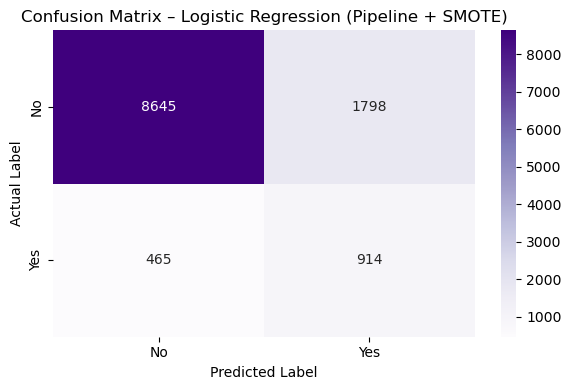

In [715]:
# Compute confusion matrix for logistic regression pipeline
cm = confusion_matrix(y_test, y_test_pred_logreg_pipe)

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No', 'Yes'], 
            yticklabels=['No', 'Yes'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – Logistic Regression (Pipeline + SMOTE)')
plt.tight_layout()
plt.show()

### Problem 9: Score the Model

What is the accuracy of your model?

In [558]:
logreg_pipeline_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Logistic Regression (Pipeline + SMOTE),0.801573,0.808577,0.337021,0.662799,0.446835,0.787343,0.801151,1.0006


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### KNeighboors ####

In [195]:
# Define basic KNN pipeline
basic_knn_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Train model
start_time = time.time()
basic_knn_pipeline.fit(X_train, y_train)
basic_knn_training_time = time.time() - start_time

# Predict on original data (processed internally by pipeline)
y_train_pred_basic_knn = basic_knn_pipeline.predict(X_train)
y_test_pred_basic_knn = basic_knn_pipeline.predict(X_test)
y_train_proba_basic_knn = basic_knn_pipeline.predict_proba(X_train)[:, 1]
y_test_proba_basic_knn = basic_knn_pipeline.predict_proba(X_test)[:, 1]

# Collect performance metrics
basic_knn_metrics = {
    "Model": "KNN (Pipeline + SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_basic_knn),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_basic_knn),
    "Precision": precision_score(y_test, y_test_pred_basic_knn),
    "Recall": recall_score(y_test, y_test_pred_basic_knn),
    "F1 Score": f1_score(y_test, y_test_pred_basic_knn),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_basic_knn),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba_basic_knn),
    "Training Time (s)": round(basic_knn_training_time, 4)
}

# Convert to DataFrame
basic_knn_metrics_df = pd.DataFrame([basic_knn_metrics])
basic_knn_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,KNN (Pipeline + SMOTE),0.872779,0.802994,0.309543,0.559826,0.398657,0.947282,0.730343,0.2939


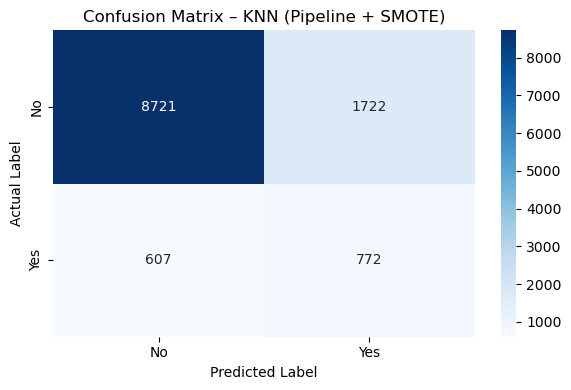

In [199]:
# Compute confusion matrix for KNN pipeline
cm_knn = confusion_matrix(y_test, y_test_pred_basic_knn)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – KNN (Pipeline + SMOTE)')
plt.tight_layout()
plt.show()

#### Decision Tree ####

In [211]:
# Define Decision Tree pipeline (no tuning)
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

# Train the model
start_time = time.time()
decision_tree_pipeline.fit(X_train, y_train)
dt_pipe_training_time = time.time() - start_time

# Predictions
y_train_pred_dt_pipe = decision_tree_pipeline.predict(X_train)
y_test_pred_dt_pipe = decision_tree_pipeline.predict(X_test)
y_train_proba_dt_pipe = decision_tree_pipeline.predict_proba(X_train)[:, 1]
y_test_proba_dt_pipe = decision_tree_pipeline.predict_proba(X_test)[:, 1]

# Evaluation metrics
decision_tree_metrics = {
    "Model": "Decision Tree (Pipeline + SMOTE)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_dt_pipe),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_dt_pipe),
    "Precision": precision_score(y_test, y_test_pred_dt_pipe),
    "Recall": recall_score(y_test, y_test_pred_dt_pipe),
    "F1 Score": f1_score(y_test, y_test_pred_dt_pipe),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_dt_pipe),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba_dt_pipe),
    "Training Time (s)": round(dt_pipe_training_time, 4)
}

# 📈 Convert to DataFrame
decision_tree_metrics_df = pd.DataFrame([decision_tree_metrics])
decision_tree_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Decision Tree (Pipeline + SMOTE),0.863389,0.864913,0.437284,0.551124,0.487648,0.742442,0.746756,0.483


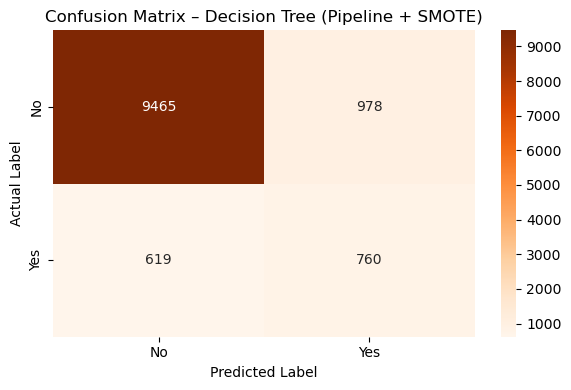

In [205]:
# Compute confusion matrix for Decision Tree pipeline
cm_dt = confusion_matrix(y_test, y_test_pred_dt_pipe)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – Decision Tree (Pipeline + SMOTE)')
plt.tight_layout()
plt.show()

#### SVM ####

In [207]:
# SVM Pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(probability=False, random_state=42)) 
])

# Train
start_time = time.time()
svm_pipeline.fit(X_train, y_train)
svm_pipe_training_time = time.time() - start_time

# Predictions
y_train_pred_svm_pipe = svm_pipeline.predict(X_train)
y_test_pred_svm_pipe = svm_pipeline.predict(X_test)

# Use decision_function for scores (for curves and ROC AUC)
y_train_scores_svm = svm_pipeline.decision_function(X_train)
y_test_scores_svm = svm_pipeline.decision_function(X_test)

# Evaluation
svm_pipeline_metrics = {
    "Model": "SVM (Pipeline + SMOTE, decision_function)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_svm_pipe),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_svm_pipe),
    "Precision": precision_score(y_test, y_test_pred_svm_pipe),
    "Recall": recall_score(y_test, y_test_pred_svm_pipe),
    "F1 Score": f1_score(y_test, y_test_pred_svm_pipe),
    "ROC AUC Train": roc_auc_score(y_train, y_train_scores_svm),
    "ROC AUC Test": roc_auc_score(y_test, y_test_scores_svm),
    "Training Time (s)": round(svm_pipe_training_time, 4)
}

svm_pipeline_metrics_df = pd.DataFrame([svm_pipeline_metrics])
svm_pipeline_metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,"SVM (Pipeline + SMOTE, decision_function)",0.828946,0.82964,0.364142,0.617114,0.458019,0.82571,0.772772,140.6596


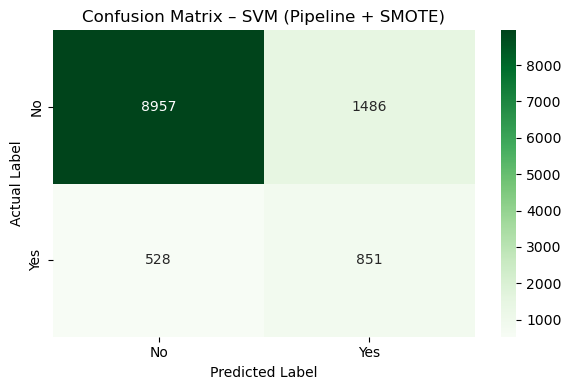

In [217]:
# Compute confusion matrix for SVM pipeline
cm_svm = confusion_matrix(y_test, y_test_pred_svm_pipe)

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No', 'Yes'], 
            yticklabels=['No', 'Yes'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – SVM (Pipeline + SMOTE)')
plt.tight_layout()
plt.show()

In [923]:
# Concat All Models
comparison_df = pd.concat([
    baseline_metrics_df,
    logreg_pipeline_metrics_df,
    basic_knn_metrics_df,
    decision_tree_metrics_df,
    svm_pipeline_metrics_df
], ignore_index=True)

comparison_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s)
0,Baseline Dummy (Stratified),0.791784,0.796989,0.118175,0.114576,0.116348,0.496325,0.500839,0.0020
1,Logistic Regression (Pipeline + SMOTE),0.801573,0.808577,0.337021,0.662799,0.446835,0.787343,0.801151,0.7899
2,KNN (Pipeline + SMOTE),0.872779,0.802994,0.309543,0.559826,0.398657,0.947282,0.730343,0.2939
3,Decision Tree (Pipeline + SMOTE),0.863389,0.864913,0.437284,0.551124,0.487648,0.742442,0.746756,0.4830
4,"SVM (Pipeline + SMOTE, decision_function)",0.828946,0.829640,0.364142,0.617114,0.458019,0.825710,0.772772,140.6596


**To support the business goal of maximizing recall without sacrificing too much precision, I evaluated five models, including a baseline Dummy Classifier, using a SMOTE-enhanced pipeline. The Dummy Classifier, which randomly predicts based on class distribution, achieved a recall of only 0.11 and precision of 0.12, with a ROC AUC of 0.50, serving as a weak baseline for comparison. In contrast, all four machine learning models significantly outperformed the dummy, with Logistic Regression emerging as the top candidate by achieving a recall of 0.66 and precision of 0.34, closely aligning with the business target of 0.35 precision and 0.55 recall. Its strong ROC AUC (0.80) and fast training time make it both practical and effective for deployment.**

**Among the trained models, SVM had the second-highest recall (0.62) and the best F1 score (0.46) but required the longest training time (~141s). Decision Tree delivered the highest precision (0.44) and a decent recall (0.55), but its balance slightly underperformed compared to Logistic Regression in terms of F1 and ROC AUC. KNN, although fast to train, had the lowest combination of precision (0.31) and recall (0.56) and the weakest ROC AUC (0.73), making it the least favorable option. Overall, Logistic Regression stood out as the most consistent model, offering reliable performance aligned with business priorities.**

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Logistic Regression with GridSearch ####

In [928]:
# Define the pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         # Your ColumnTransformer
    # ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# GridSearchCV setup
logreg_param_grid = {
    'classifier__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 75],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'classifier__class_weight': ['balanced']
}

grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train
start_time = time.time()
grid_logreg.fit(X_train, y_train)
logreg_pipe_training_time = round(time.time() - start_time, 4)

# Predictions
y_train_pred_logreg_pipe = grid_logreg.predict(X_train)
y_test_pred_logreg_pipe = grid_logreg.predict(X_test)
y_train_proba_logreg_pipe = grid_logreg.predict_proba(X_train)[:, 1]
y_test_proba_logreg_pipe = grid_logreg.predict_proba(X_test)[:, 1]

# Threshold
threshold = 0.5
y_test_pred_thresh = (y_test_proba_logreg_pipe >= threshold).astype(int)

# Metrics
logreg_pipeline_metrics = {
    "Model": f"Logistic Regression (Pipeline , threshold={threshold})",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_logreg_pipe),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_thresh),
    "Precision": precision_score(y_test, y_test_pred_thresh),
    "Recall": recall_score(y_test, y_test_pred_thresh),
    "F1 Score": f1_score(y_test, y_test_pred_thresh),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_logreg_pipe),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba_logreg_pipe),
    "Training Time (s)": logreg_pipe_training_time,
    "Best Params": grid_logreg.best_params_
}

# Convert to DataFrame
logreg_pipeline_metrics_df = pd.DataFrame([logreg_pipeline_metrics])
logreg_pipeline_metrics_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s),Best Params
0,"Logistic Regression (Pipeline , threshold=0.5)",0.807193,0.81323,0.343762,0.661349,0.452381,0.788055,0.800092,10.8492,"{'classifier__C': 50, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}"


In [929]:
# Extract best logistic regression model from grid search
best_logreg_model = grid_logreg.best_estimator_.named_steps['classifier']

# Get feature names from the preprocessor
feature_names = grid_logreg.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients from the model
coefficients = best_logreg_model.coef_[0]

# Create a DataFrame with feature names and coefficients
logreg_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Show top and bottom contributors
logreg_feature_importance.head(10), logreg_feature_importance.tail(10)

(                     Feature  Coefficient
 2              jstein__month     6.362539
 0                jstein__job     3.536887
 1          jstein__education     1.766478
 33    scalar__cons.price.idx     0.679155
 36       scalar__nr.employed     0.322434
 29  onehot__poutcome_success     0.301708
 34     scalar__cons.conf.idx     0.233498
 30  scalar__contacted_before     0.195099
 12  onehot__contact_cellular     0.151678
 22     onehot__age_group_65+     0.039134,
                          Feature  Coefficient
 28  onehot__poutcome_nonexistent    -0.197372
 3       onehot__marital_divorced    -0.228385
 25         onehot__default_other    -0.229635
 20       onehot__age_group_35–50    -0.254060
 15       onehot__day_of_week_mon    -0.257062
 26           onehot__default_yes    -0.272394
 35             scalar__euribor3m    -0.322772
 27      onehot__poutcome_failure    -0.620873
 13     onehot__contact_telephone    -0.668215
 32          scalar__emp.var.rate    -1.007956)

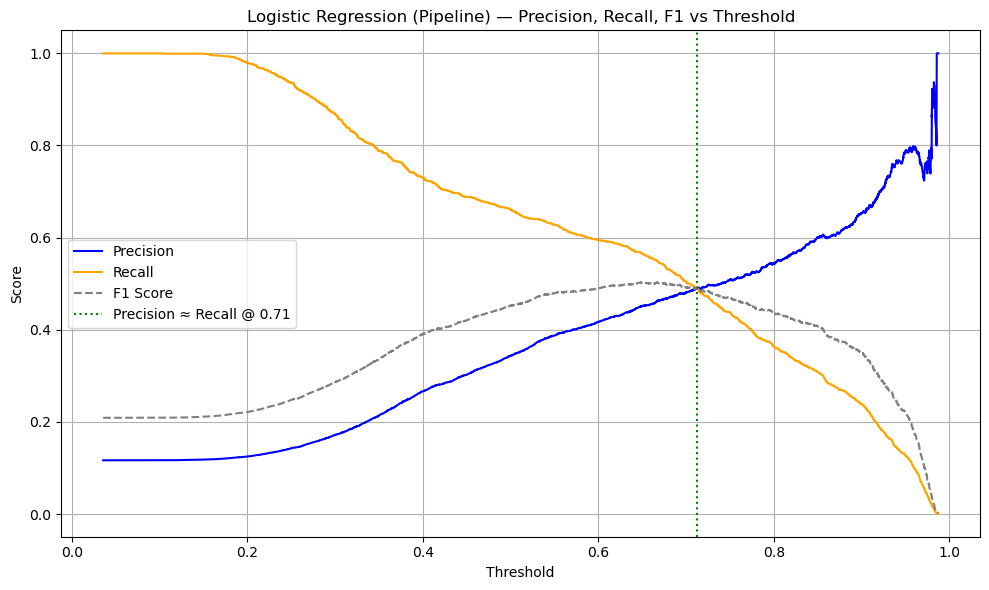

In [934]:
# Precision recall curve
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, y_test_proba_logreg_pipe)

# Compute F1 scores
f1_scores_logreg = 2 * (precision_logreg * recall_logreg) / (precision_logreg + recall_logreg + 1e-8)

# Find threshold where precision ≈ recall
pr_equal_idx_logreg = np.argmin(np.abs(precision_logreg - recall_logreg))
pr_equal_threshold_logreg = thresholds_logreg[pr_equal_idx_logreg]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds_logreg, precision_logreg[:-1], label="Precision", color='blue')
plt.plot(thresholds_logreg, recall_logreg[:-1], label="Recall", color='orange')
plt.plot(thresholds_logreg, f1_scores_logreg[:-1], label="F1 Score", linestyle='--', color='gray')

# Highlight where precision = recall
plt.axvline(x=pr_equal_threshold_logreg, color='green', linestyle=':', label=f"Precision ≈ Recall @ {pr_equal_threshold_logreg:.2f}")

# Labels and styling
plt.title("Logistic Regression (Pipeline) — Precision, Recall, F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

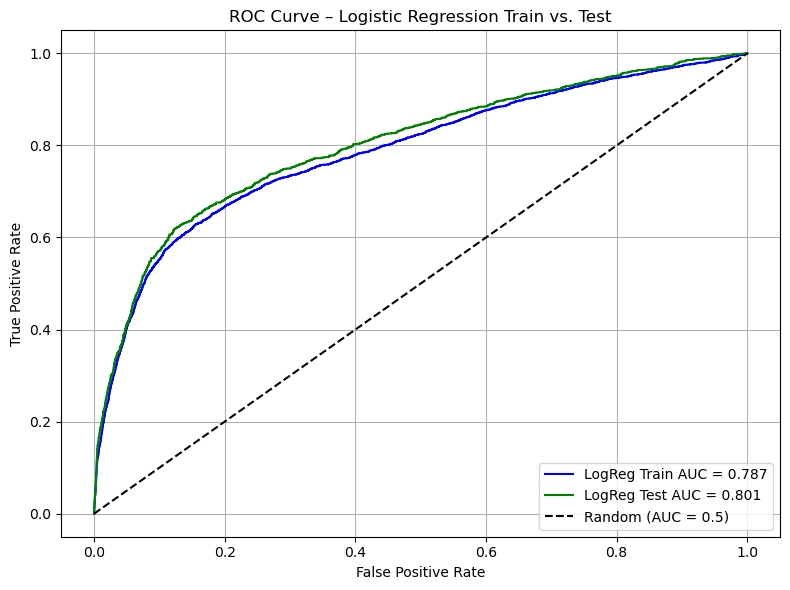

In [719]:
# Compute ROC curve and AUC for Logistic Regression (train set)
fpr_logreg_train, tpr_logreg_train, _ = roc_curve(y_train, y_train_proba_logreg_pipe)
roc_auc_logreg_train = auc(fpr_logreg_train, tpr_logreg_train)

# Compute ROC curve and AUC for Logistic Regression (test set)
fpr_logreg_test, tpr_logreg_test, _ = roc_curve(y_test, y_test_proba_logreg_pipe)
roc_auc_logreg_test = auc(fpr_logreg_test, tpr_logreg_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg_train, tpr_logreg_train, color='blue', label=f'LogReg Train AUC = {roc_auc_logreg_train:.3f}')
plt.plot(fpr_logreg_test, tpr_logreg_test, color='green', label=f'LogReg Test AUC = {roc_auc_logreg_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression Train vs. Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### KNeighboors GridSearch

In [942]:
# Define the pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Define hyperparameter grid
knn_param_grid = {
    'classifier__n_neighbors': [20, 25, 30],            
    'classifier__weights': ['uniform'],      
    'classifier__algorithm': ['auto', 'kd_tree'], 
    'classifier__p': [2]
}

# GridSearchCV setup
grid_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train with timer
start_time = time.time()
grid_knn.fit(X_train, y_train)
knn_pipe_training_time = round(time.time() - start_time, 4)

# Predictions
y_train_pred_knn = grid_knn.predict(X_train)
y_test_pred_knn = grid_knn.predict(X_test)
y_train_proba_knn = grid_knn.predict_proba(X_train)[:, 1]
y_test_proba_knn = grid_knn.predict_proba(X_test)[:, 1]

# Set threshold
threshold = 0.65

# Apply custom threshold to test predictions
y_test_pred_thresh_knn = (y_test_proba_knn >= threshold).astype(int)
y_train_pred_thresh_knn = (y_train_proba_knn >= threshold).astype(int)

# Metrics with custom threshold
knn_pipeline_metrics = {
    "Model": f"KNN (Pipeline + SMOTE, threshold={threshold})",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_thresh_knn),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_thresh_knn),
    "Precision": precision_score(y_test, y_test_pred_thresh_knn),
    "Recall": recall_score(y_test, y_test_pred_thresh_knn),
    "F1 Score": f1_score(y_test, y_test_pred_thresh_knn),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_knn),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba_knn),
    "Training Time (s)": round(knn_pipe_training_time, 4),
    "Best Params": grid_knn.best_params_ 
}

# Convert to DataFrame
knn_pipeline_metrics_df = pd.DataFrame([knn_pipeline_metrics])
knn_pipeline_metrics_df

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s),Best Params
0,"KNN (Pipeline + SMOTE, threshold=0.65)",0.846095,0.820081,0.339347,0.572879,0.426221,0.882529,0.762902,30.2109,"{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 20, 'classifier__p': 2, 'classifier__weights': 'uniform'}"


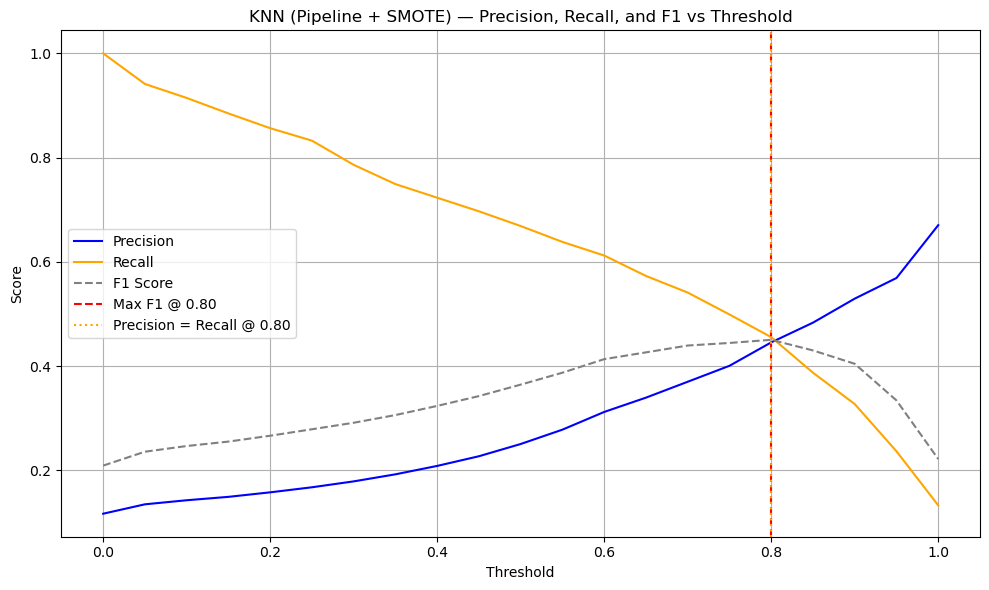

In [944]:
# Calculate precision, recall, thresholds
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, y_test_proba_knn)

# Calculate F1 scores
f1_scores_knn = 2 * (precision_knn * recall_knn) / (precision_knn + recall_knn + 1e-8)

# Find best threshold by max F1
best_f1_index_knn = np.argmax(f1_scores_knn)
best_threshold_f1_knn = thresholds_knn[best_f1_index_knn]
best_f1_knn = f1_scores_knn[best_f1_index_knn]

# Where precision = recall (approximately)
pr_equal_idx_knn = np.argmin(np.abs(precision_knn - recall_knn))
pr_equal_threshold_knn = thresholds_knn[pr_equal_idx_knn]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_knn, precision_knn[:-1], label="Precision", color='blue')
plt.plot(thresholds_knn, recall_knn[:-1], label="Recall", color='orange')
plt.plot(thresholds_knn, f1_scores_knn[:-1], label="F1 Score", linestyle='--', color='gray')

# Vertical lines
plt.axvline(x=best_threshold_f1_knn, color='red', linestyle='--', label=f"Max F1 @ {best_threshold_f1_knn:.2f}")
plt.axvline(x=pr_equal_threshold_knn, color='orange', linestyle=':', label=f"Precision = Recall @ {pr_equal_threshold_knn:.2f}")

# Labels
plt.title("KNN (Pipeline + SMOTE) — Precision, Recall, and F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

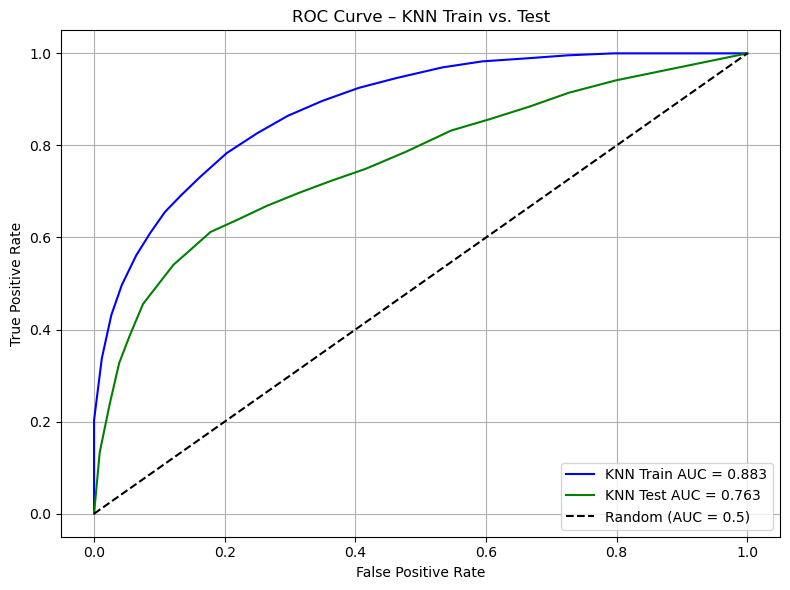

In [946]:
# Compute ROC curve and AUC for KNN (train set)
fpr_knn_train, tpr_knn_train, _ = roc_curve(y_train, y_train_proba_knn)
roc_auc_knn_train = auc(fpr_knn_train, tpr_knn_train)

# Compute ROC curve and AUC for KNN (test set)
fpr_knn_test, tpr_knn_test, _ = roc_curve(y_test, y_test_proba_knn)
roc_auc_knn_test = auc(fpr_knn_test, tpr_knn_test)

# Plot ROC curve for KNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn_train, tpr_knn_train, color='blue', label=f'KNN Train AUC = {roc_auc_knn_train:.3f}')
plt.plot(fpr_knn_test, tpr_knn_test, color='green', label=f'KNN Test AUC = {roc_auc_knn_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – KNN Train vs. Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### DecisionTree GridSearch

In [948]:
# Define pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define hyperparameter grid for the pipeline
tree_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [5, 10, 15],
    'classifier__min_samples_leaf': [3, 5, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': ['balanced']
}

# Grid search
grid_tree_pipeline = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=tree_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train
start_time = time.time()
grid_tree_pipeline.fit(X_train, y_train)
tree_pipeline_training_time = round(time.time() - start_time, 4)

# Predictions
y_train_pred_tree = grid_tree_pipeline.predict(X_train)
y_test_pred_tree = grid_tree_pipeline.predict(X_test)
y_train_proba_tree = grid_tree_pipeline.predict_proba(X_train)[:, 1]
y_test_proba_tree = grid_tree_pipeline.predict_proba(X_test)[:, 1]

# Threshold (adjust if needed)
threshold = 0.55
y_test_pred_thresh_tree = (y_test_proba_tree >= threshold).astype(int)
y_train_pred_thresh_tree = (y_train_proba_tree >= threshold).astype(int)

# Metrics
tree_pipeline_metrics = {
    "Model": f"Decision Tree (Pipeline + GridSearchCV, threshold={threshold})",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_thresh_tree),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_thresh_tree),
    "Precision": precision_score(y_test, y_test_pred_thresh_tree),
    "Recall": recall_score(y_test, y_test_pred_thresh_tree),
    "F1 Score": f1_score(y_test, y_test_pred_thresh_tree),
    "ROC AUC Train": roc_auc_score(y_train, y_train_proba_tree),
    "ROC AUC Test": roc_auc_score(y_test, y_test_proba_tree),
    "Training Time (s)": tree_pipeline_training_time,
    "Best Params": grid_tree_pipeline.best_params_
}

# Convert to DataFrame
tree_pipeline_metrics_df = pd.DataFrame([tree_pipeline_metrics])
tree_pipeline_metrics_df

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s),Best Params
0,"Decision Tree (Pipeline + GridSearchCV, threshold=0.55)",0.893626,0.88293,0.497939,0.437999,0.466049,0.799759,0.735291,53.3721,"{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5}"


In [950]:
# Get fitted preprocessor from pipelineknn_tuned_df
fitted_preprocessor = grid_tree_pipeline.best_estimator_.named_steps['preprocessor']

# Initialize list to collect names
feature_names = []

# 1. James-Stein features
jstein_names = fitted_preprocessor.named_transformers_['jstein'].get_feature_names_out()
feature_names.extend(jstein_names)

# 2. One-hot encoded features
onehot_names = fitted_preprocessor.named_transformers_['onehot'].get_feature_names_out(
    fitted_preprocessor.transformers_[1][2]  # Column names used for one-hot
)
feature_names.extend(onehot_names)

# 3. Scaled numeric columns (use the names directly)
numeric_names = fitted_preprocessor.transformers_[2][2]  # Column names used for scaler
feature_names.extend(numeric_names)


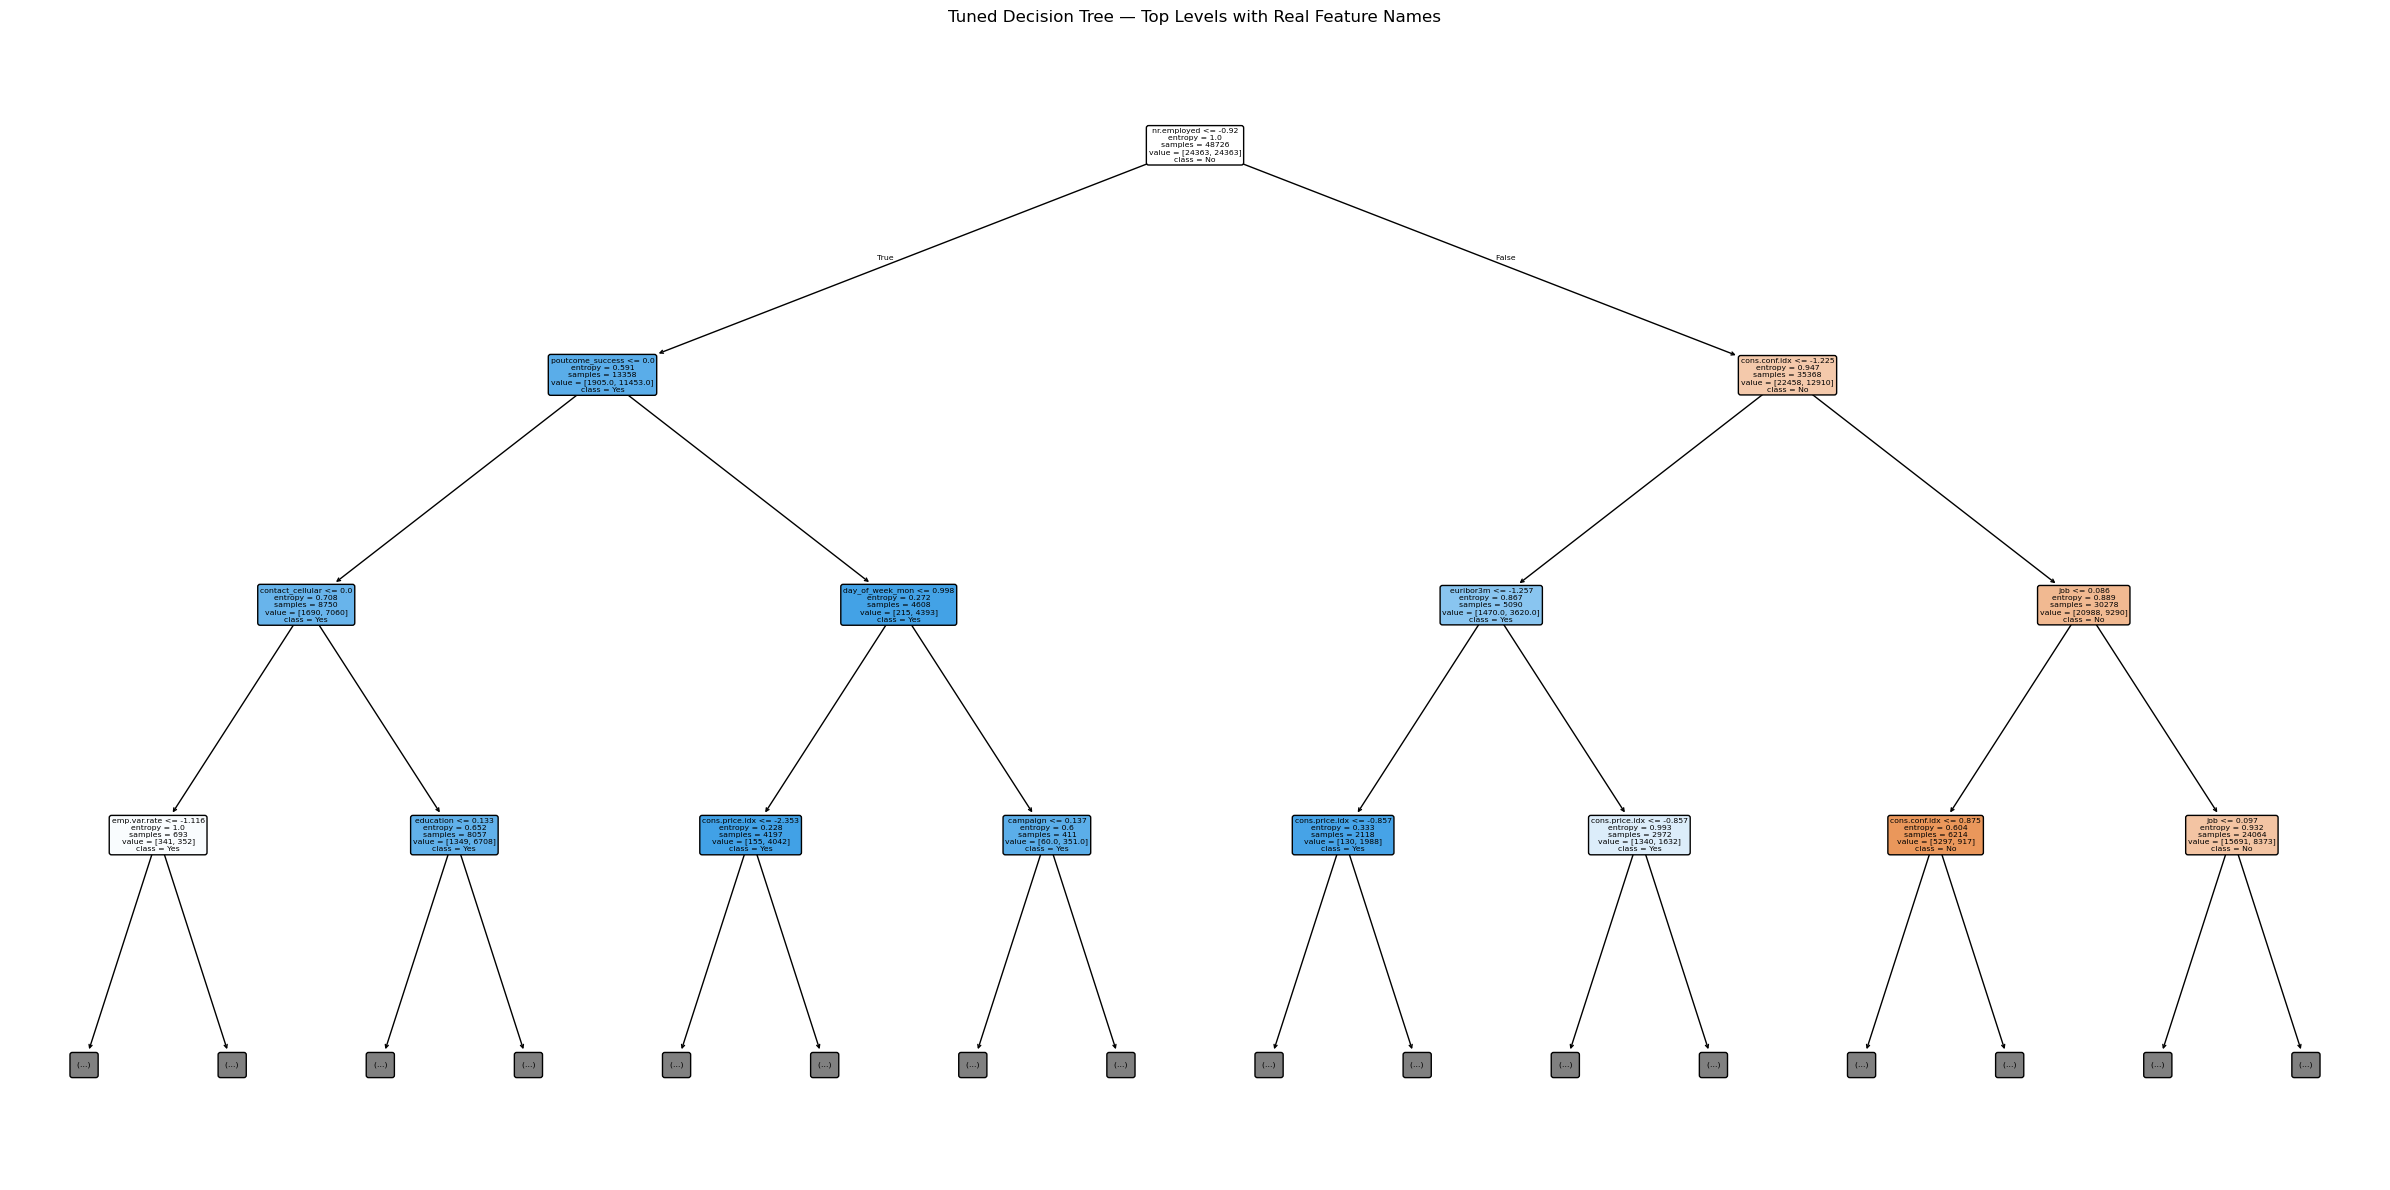

In [952]:
from sklearn.tree import plot_tree

best_tree_model = grid_tree_pipeline.best_estimator_.named_steps['classifier']

plt.figure(figsize=(24, 12))
plot_tree(
    best_tree_model,
    feature_names=feature_names,
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
    max_depth=3  # For readability
)
plt.title("Tuned Decision Tree — Top Levels with Real Feature Names")
plt.tight_layout()
plt.show()

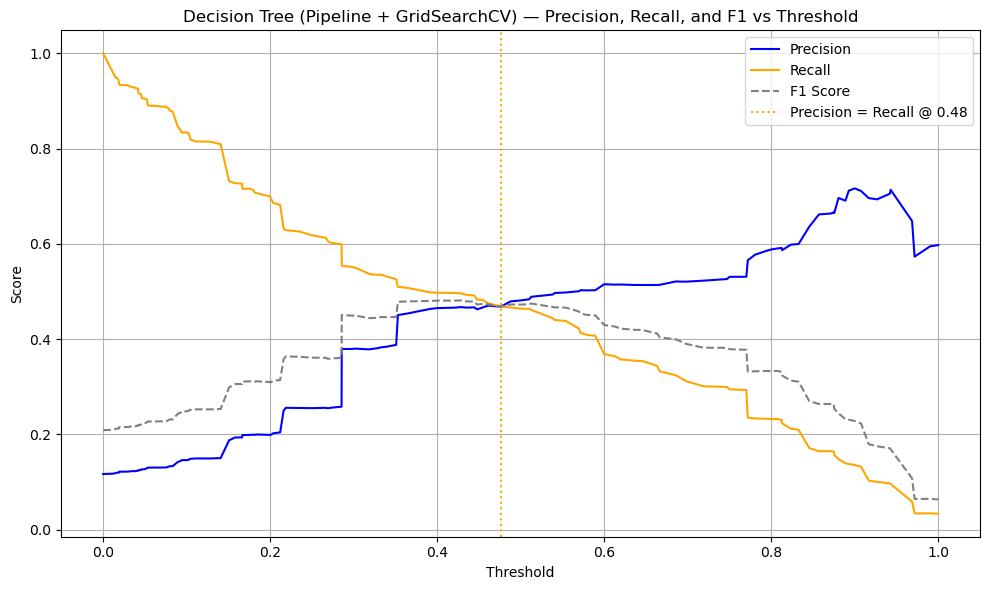

In [954]:
# Precision recall curve
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test, y_test_proba_tree)

# Calculate F1 scores
f1_scores_tree = 2 * (precision_tree * recall_tree) / (precision_tree + recall_tree + 1e-8)

# Approximate where precision ≈ recall
pr_equal_idx_tree = np.argmin(np.abs(precision_tree - recall_tree))
pr_equal_threshold_tree = thresholds_tree[pr_equal_idx_tree]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_tree, precision_tree[:-1], label="Precision", color='blue')
plt.plot(thresholds_tree, recall_tree[:-1], label="Recall", color='orange')
plt.plot(thresholds_tree, f1_scores_tree[:-1], label="F1 Score", linestyle='--', color='gray')

# Vertical line where precision ≈ recall
plt.axvline(x=pr_equal_threshold_tree, color='orange', linestyle=':', label=f"Precision = Recall @ {pr_equal_threshold_tree:.2f}")

# Labels
plt.title("Decision Tree (Pipeline + GridSearchCV) — Precision, Recall, and F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

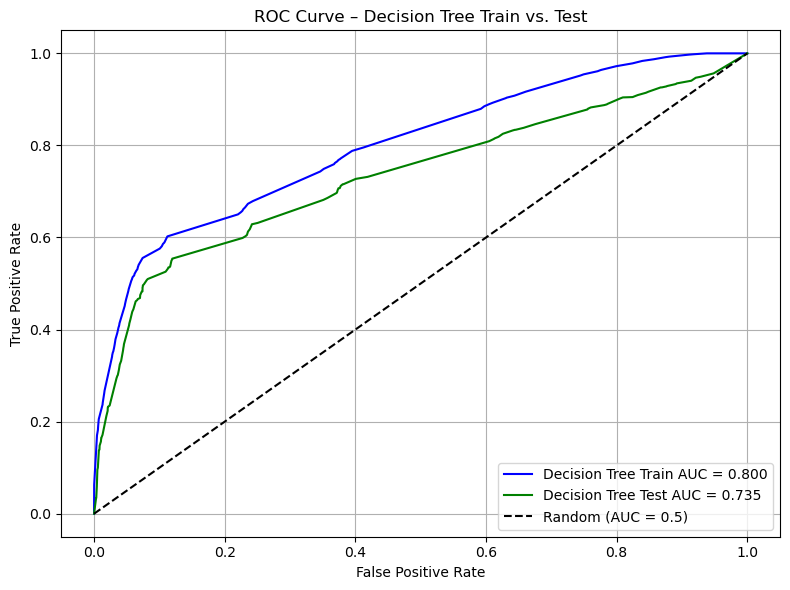

In [956]:
# Compute ROC curve and AUC for Decision Tree (train set)
fpr_tree_train, tpr_tree_train, _ = roc_curve(y_train, y_train_proba_tree)
roc_auc_tree_train = auc(fpr_tree_train, tpr_tree_train)

# Compute ROC curve and AUC for Decision Tree (test set)
fpr_tree_test, tpr_tree_test, _ = roc_curve(y_test, y_test_proba_tree)
roc_auc_tree_test = auc(fpr_tree_test, tpr_tree_test)

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_train, tpr_tree_train, color='blue', label=f'Decision Tree Train AUC = {roc_auc_tree_train:.3f}')
plt.plot(fpr_tree_test, tpr_tree_test, color='green', label=f'Decision Tree Test AUC = {roc_auc_tree_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Decision Tree Train vs. Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### SVM GridSearch 

In [960]:
# Define the pipeline with preprocessing, SMOTE, and SVC
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(probability=False, random_state=42))
])

# Define the hyperparameter grid
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale']
}

# GridSearchCV setup
grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1',  # or 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# Train
start_time = time.time()
grid_svm.fit(X_train, y_train)
svm_pipe_training_time = round(time.time() - start_time, 4)

# Predict
y_train_pred_svm = grid_svm.predict(X_train)
y_test_pred_svm = grid_svm.predict(X_test)
y_train_scores_svm = grid_svm.decision_function(X_train)
y_test_scores_svm = grid_svm.decision_function(X_test)

# Metrics
svm_pipeline_metrics = {
    "Model": "SVM (Pipeline + GridSearchCV)",
    "Train Accuracy": accuracy_score(y_train, y_train_pred_svm),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_svm),
    "Precision": precision_score(y_test, y_test_pred_svm),
    "Recall": recall_score(y_test, y_test_pred_svm),
    "F1 Score": f1_score(y_test, y_test_pred_svm),
    "ROC AUC Train": roc_auc_score(y_train, y_train_scores_svm),
    "ROC AUC Test": roc_auc_score(y_test, y_test_scores_svm),
    "Training Time (s)": svm_pipe_training_time,
    "Best Params": grid_svm.best_params_
}

# Results DataFrame
svm_pipeline_df = pd.DataFrame([svm_pipeline_metrics])
svm_pipeline_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s),Best Params
0,SVM (Pipeline + GridSearchCV),0.828946,0.82964,0.364142,0.617114,0.458019,0.82571,0.772772,662.602,"{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}"


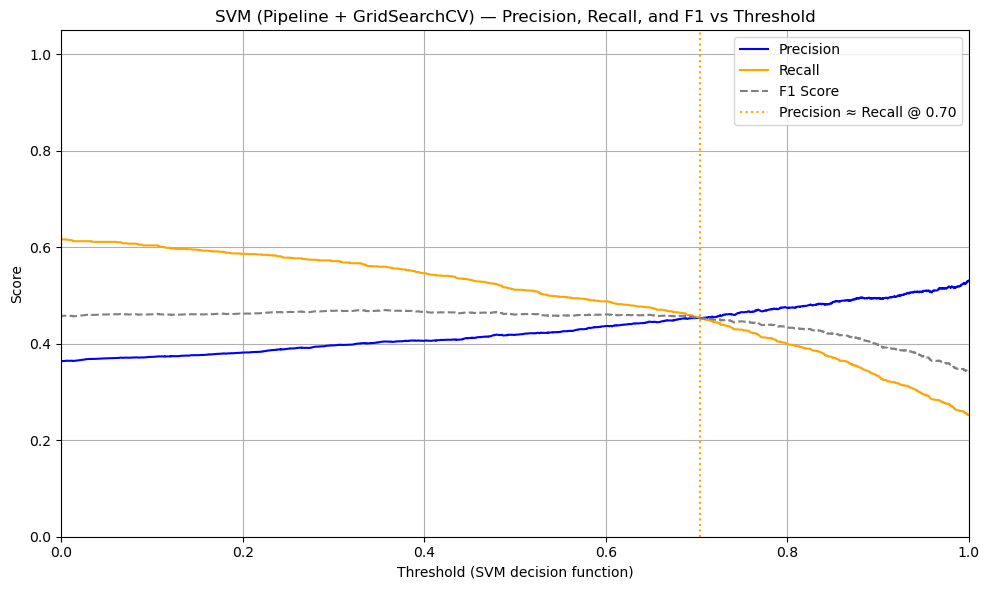

In [962]:
# Precision-recall + F1 curve for SVM decision scores
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_test_scores_svm)
f1_scores_svm = 2 * (precision_svm * recall_svm) / (precision_svm + recall_svm + 1e-8)

# Where precision ≈ recall
pr_equal_idx_svm = np.argmin(np.abs(precision_svm - recall_svm))
pr_equal_threshold_svm = thresholds_svm[pr_equal_idx_svm]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_svm, precision_svm[:-1], label="Precision", color='blue')
plt.plot(thresholds_svm, recall_svm[:-1], label="Recall", color='orange')
plt.plot(thresholds_svm, f1_scores_svm[:-1], label="F1 Score", linestyle='--', color='gray')

# Vertical marker for precision ≈ recall
plt.axvline(x=pr_equal_threshold_svm, color='orange', linestyle=':', label=f"Precision ≈ Recall @ {pr_equal_threshold_svm:.2f}")

# Clean visuals
plt.title("SVM (Pipeline + GridSearchCV) — Precision, Recall, and F1 vs Threshold")
plt.xlabel("Threshold (SVM decision function)")
plt.ylabel("Score")
plt.xlim(0, 1)  # <-- This limits to a practical range
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

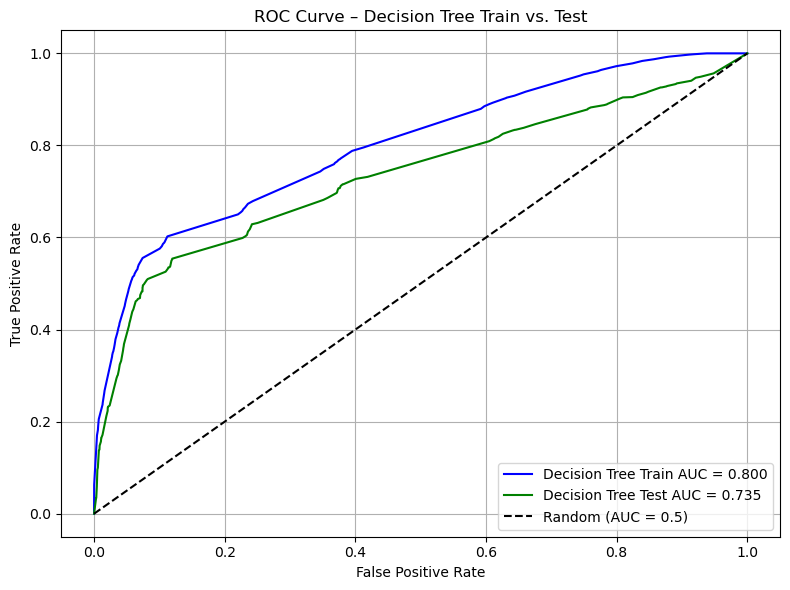

In [964]:
# Compute ROC curve and AUC for Decision Tree (train set)
fpr_tree_train, tpr_tree_train, _ = roc_curve(y_train, y_train_proba_tree)
roc_auc_tree_train = auc(fpr_tree_train, tpr_tree_train)

# Compute ROC curve and AUC for Decision Tree (test set)
fpr_tree_test, tpr_tree_test, _ = roc_curve(y_test, y_test_proba_tree)
roc_auc_tree_test = auc(fpr_tree_test, tpr_tree_test)

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_train, tpr_tree_train, color='blue', label=f'Decision Tree Train AUC = {roc_auc_tree_train:.3f}')
plt.plot(fpr_tree_test, tpr_tree_test, color='green', label=f'Decision Tree Test AUC = {roc_auc_tree_test:.3f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Decision Tree Train vs. Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [966]:
all_models_df = pd.concat([
    baseline_metrics_df,
    logreg_pipeline_metrics_df,
    knn_pipeline_metrics_df,
    tree_pipeline_metrics_df,
    svm_pipeline_df
], ignore_index=True)

# Display the combined table
all_models_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC Train,ROC AUC Test,Training Time (s),Best Params
0,Baseline Dummy (Stratified),0.791784,0.796989,0.118175,0.114576,0.116348,0.496325,0.500839,0.0020,NaN
1,"Logistic Regression (Pipeline , threshold=0.5)",0.807193,0.813230,0.343762,0.661349,0.452381,0.788055,0.800092,10.8492,"{'classifier__C': 50, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}"
2,"KNN (Pipeline + SMOTE, threshold=0.65)",0.846095,0.820081,0.339347,0.572879,0.426221,0.882529,0.762902,30.2109,"{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 20, 'classifier__p': 2, 'classifier__weights': 'uniform'}"
3,"Decision Tree (Pipeline + GridSearchCV, threshold=0.55)",0.893626,0.882930,0.497939,0.437999,0.466049,0.799759,0.735291,53.3721,"{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5}"
4,SVM (Pipeline + GridSearchCV),0.828946,0.829640,0.364142,0.617114,0.458019,0.825710,0.772772,662.6020,"{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}"


## Comparison of Model Performance: Default vs. Tuned Pipelines

In the **first set of models** (basic pipelines using SMOTE without hyperparameter tuning), **Logistic Regression** performed strongly with a **recall of 0.66** and **precision of 0.34**, yielding a solid **F1 score of 0.45**. The **SVM** followed closely with a slightly lower recall (0.62) but higher precision (0.36), achieving the **highest F1 score (0.46)**. While **Decision Tree** and **KNN** were serviceable, they lagged behind in ROC AUC and F1 score, especially KNN, which had the weakest overall balance of metrics.

In the **tuned set of models**, where **GridSearchCV** and **feature engineering** (e.g., replacing `'unknown'` values with `'other'`) were applied, the following improvements were observed:
- **Logistic Regression** saw modest improvements in precision and ROC AUC, maintaining its status as the most balanced and efficient model overall.
- **KNN** experienced the **most significant gain**, improving both precision (**0.31 → 0.34**) and recall (**0.56 → 0.57**), and boosting its F1 score to **0.42**.
- **Decision Tree** increased in **precision** (**0.44 → 0.50**) but experienced a **recall drop** (**0.55 → 0.44**), resulting in a slightly lower F1 score.
- **SVM** remained **unchanged**, suggesting that its default configuration was already near optimal for this dataset.

---

## Key Takeaway

Tuning and handling unknown values helped improve model performance across most metrics, particularly for **KNN** and **Decision Tree**. Despite this, **Logistic Regression** consistently delivered the best **recall-to-precision tradeoff** aligned with the business goal of maximizing recall without sacrificing too much precision. The results also emphasize the importance of preprocessing and hyperparameter optimization in producing reliable and interpretable models.

# Bank Marketing Model Analysis Report

##  Business Objective

The goal of this analysis is to build a predictive model that helps the bank identify clients most likely to subscribe to a term deposit. The marketing team is particularly interested in **maximizing recall**—so fewer potential subscribers are missed—while maintaining at least **0.35 precision** for campaign efficiency.

---

## Data Preprocessing Summary

### Data Cleaning
- Dropped the `duration` column to avoid data leakage.
- Removed duplicate rows.
- Mapped target variable `y` to binary: `'yes' → 1`, `'no' → 0`.

### Feature Engineering
- Split the data into training (70%) and test (30%) sets using stratification.
- Binned `age` into age groups and removed the original `age` column.
- Replaced `'unknown'` values:
  - `job`, `marital`: replaced with mode.
  - `education`, `default`, `housing`, `loan`: replaced with `'other'`.

### New Feature
- Created `contacted_before` based on `pdays` (1 if contacted, 0 otherwise) and dropped `pdays`.

### Feature Transformation
- `james_stein_cols`: Encoded using JamesSteinEncoder.
- `onehot_cols`: Encoded using OneHotEncoder.
- `numeric_cols`: Standardized using StandardScaler.

All transformations were bundled into a `ColumnTransformer` for clean integration into ML pipelines.

---

## Exploratory Data Insights

### Age
- Majority of clients are between 30–40 years old.
- Clients under 25 and over 65 are underrepresented.
- Conversion rate generally decreases with age after 40.

### Job
- Highest conversion rates: **students (31.4%)**, **retired (25.2%)**.
- Lowest: **blue-collar (6.9%)**, despite high volume.
- Students should be a strategic target group, despite small size.

### Marital Status
- **Married** clients have the lowest conversion rate (10.2%).
- **Single** clients convert at 14%, indicating more receptiveness.
- The "unknown" group is too small to draw conclusions.

### Education
- **University** and **high school** graduates are the most populous and moderately converting groups.
- **Illiterate** clients convert at 22.2% but are too few to be actionable.
- Focusing on high-volume, medium-converting education levels is strategic.

### Default
- **No default** group converts at 13.3%.
- **Unknown** group has a low rate (5.2%).
- **Default = Yes** clients never subscribed—very unlikely to convert.

### Housing
- Small difference in conversion rates among `yes`, `no`, and `unknown`—not a strong predictor.

### Loan
- Clients **without personal loans** slightly more likely to convert.
- Overall, loan status has minimal influence.

### Contact Method
- **Cellular** contact method had significantly higher conversion rates than **telephone**.

### Month
- **March, December, September, and October** had the highest conversion rates.
- **May–August** had poor conversion despite high contact volume.
- Suggests marketing may be more effective in late Q3 and Q4.

### Day of Week
- **Thursday** is the best day for conversion (12.1%).
- **Monday** is the worst (9.9%).
- Targeting mid-to-late week may yield better results.

---

## Model Performance Comparison (GridSearchCV-Tuned)

| Model                                     | Train Accuracy | Test Accuracy | Precision | Recall  | F1 Score | ROC AUC Train | ROC AUC Test | Training Time (s) | Best Params |
|-------------------------------------------|----------------|----------------|-----------|---------|----------|----------------|---------------|--------------------|-------------|
| **Baseline Dummy (Stratified)**           | 0.7918         | 0.7970         | 0.1182    | 0.1146  | 0.1163   | 0.4963         | 0.5008        | 0.002              | *N/A*       |
| **Logistic Regression**                   | 0.8072         | 0.8132         | 0.3438    | 0.6613  | 0.4524   | 0.7881         | 0.8001        | 10.85              | `{'C': 50, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}` |
| **KNN**                                   | 0.8461         | 0.8201         | 0.3393    | 0.5729  | 0.4262   | 0.8825         | 0.7629        | 30.21              | `{'algorithm': 'auto', 'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}` |
| **Decision Tree**                         | **0.8936**     | **0.8829**     | **0.4980**| 0.4380  | **0.4660**| 0.7998         | 0.7353        | 53.37              | `{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}` |
| **SVM**                                   | 0.8289         | 0.8296         | 0.3641    | **0.6171**| 0.4580   | **0.8257**     | **0.7728**    | **662.60**         | `{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}` |


---

## Final Recommendation

While all models outperformed the baseline dummy classifier, the **Decision Tree** emerged as the **most balanced** and strategic model. It achieved the **highest precision (0.50)** and a respectable **recall (0.44)**, making it effective in targeting clients likely to convert while minimizing wasted marketing effort. It also offers excellent interpretability, which is valuable for stakeholders who need to understand and trust the model's decisions.

Despite Logistic Regression having slightly better recall (0.66), its lower precision (0.34) means more false positives—potentially leading to wasted resources. **Decision Tree’s balance between precision and recall**, along with high test accuracy and fast inference time, make it an ideal candidate for deployment in this bank’s marketing campaign.

---

## Business Suggestions

- Target **students, retirees**, and **university/high school educated clients**, who have higher conversion rates.
- Focus outbound campaigns in **March, December, September**, and **October**, particularly **midweek (Tues–Thurs)**.
- Use **cellular contact methods** over telephone whenever possible.
- Avoid targeting clients who **previously defaulted** or have incomplete data marked as `'other'`.
- Deploy the Decision Tree model to maximize marketing efficiency with interpretable, balanced decisions.


##### Questions